In [5]:
# Installing OpenCV
!pip3 install opencv-python

In [6]:
# Loading necesary libraries

import os
import gc
import cv2
import time
import json
import base64
import requests
import pytesseract
import multiprocessing
from io import BytesIO
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [107]:
# Define the path to the directory containing the images

IMGS_PATH = '/home/jovyan/__ANIMALS/images'
N_CORES = 8
URL_OCR_SERVICE = 'https://ocr.api.cloud.yandex.net/ocr/v1/recognizeText'  # URL for the Yandex OCR service API

In [4]:
# Get a list of image files in the director
img_files = [x for x in os.listdir(IMGS_PATH) if '.JPG' in x] # Only include JPG files
print(len(img_files))
print(img_files[:3])

7054
['Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG', 'Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG', 'Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG']


In [10]:
# Load and display one of the images

file_path = f'{IMGS_PATH}/{img_files[-2]}' # Get the path of the second-to-last image
img = cv2.imread(file_path) # Read the image using OpenCV

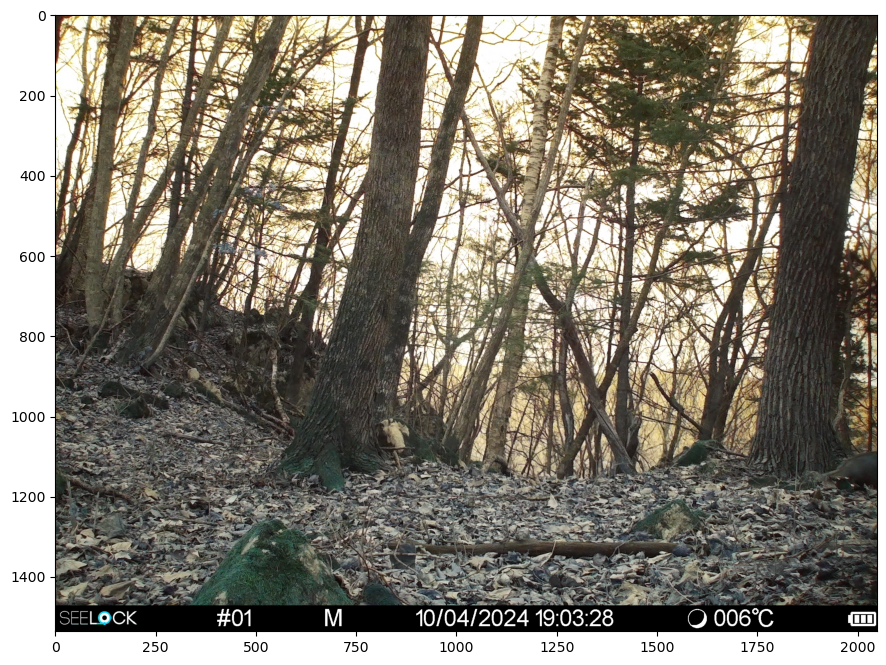

In [11]:
# Display the image using matplotlib

plt.figure(figsize=(16, 8))
plt.imshow(img)
plt.show()

In [12]:
# Extract shapes of all images in the directory

shapes = []
for img_file in tqdm(img_files):
    file_path = f'{IMGS_PATH}/{img_file}'
    img = cv2.imread(file_path)
    shapes.append(img.shape) # Append the shape of the image (height, width, channels)
print(set(shapes))

  0%|          | 0/7054 [00:00<?, ?it/s]

{(958, 1704, 3), (1536, 2048, 3), (1944, 2592, 3), (1080, 1920, 3)}


In [14]:
# Using multiprocessing to speed up the process of getting image shapes

%time


def img_shape(img_file):
    """
    Fast multiprocessing.
    
    """
    file_path = f'{IMGS_PATH}/{img_file}'
    img = cv2.imread(file_path)
    return img.shape


with multiprocessing.Pool(N_CORES) as pool:
    shapes = pool.map(img_shape, img_files)
    pool.close()
    pool.join()
print(set(shapes))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
{(958, 1704, 3), (1536, 2048, 3), (1944, 2592, 3), (1080, 1920, 3)}



### Insights on Image Orientation and Aspect Ratio Analysis

In this analysis, we examined the orientation and aspect ratio distribution of the data

1. **Image Resolutions:**
   - The dataset contains **four unique resolutions**, represented as `(height, width, channels)`:
     - `(958, 1704, 3)`
     - `(1536, 2048, 3)`
     - `(1944, 2592, 3)`
     - `(1080, 1920, 3)`
     
   - The presence of multiple resolutions indicates that the dataset is not uniform, which could require preprocessing steps such as resizing or normalization to standardize image dimensions before applying machine learning models.

2. **Aspect Ratios:**
   - Aspect ratios were calculated as `height / width` for all unique resolutions:
     - **0.5622**, **0.5625**, **0.75** (occurring twice due to different resolutions with the same aspect ratio).
   - These values suggest that all images are significantly wider than they are tall, which aligns with a predominantly `landscape` orientation.

3. **Orientation Classification:**
   - Based on the aspect ratios and a classification tolerance of `0.15`:
     - **Landscape Images:** All images were classified as `landscape`.
     - **Portrait and Square Images:** No images were classified as `portrait` or `square`.
   - This indicates that the dataset is homogeneously oriented towards landscape images.



In [15]:
# Calculate aspect ratios (height/width) of the images

for s in set(shapes):
    print(s[0] / s[1])

0.562206572769953
0.75
0.75
0.5625


### Image Orientation

Here we will:
Check the orientation of the images (landscape vs portrait). This can guide how to resize or crop them uniformly for analysis.

We will output the different kinds of aspect ratio image samples

{'landscape': 4, 'portrait': 0, 'square': 0}
{'landscape': 4, 'portrait': 0, 'square': 0}


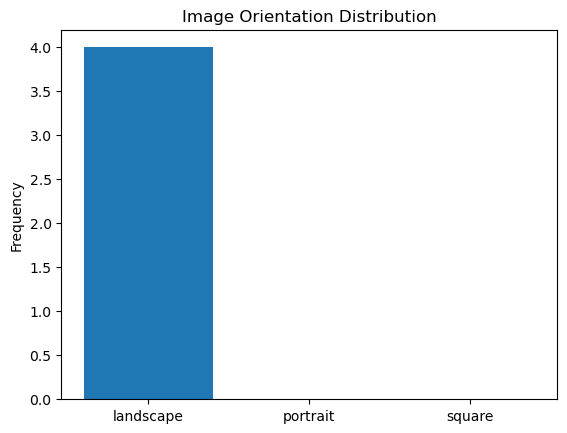

In [37]:
def classify_orientation(shape):
  """Classifies image orientation based on aspect ratio."""
  h, w, _ = shape
  aspect_ratio = h / w
  tolerance = 0.15

  if aspect_ratio > 1 + tolerance:
    return 'portrait'
  elif aspect_ratio < 1 - tolerance:
    return 'landscape'
  else:
    return 'square'

orientations = {'landscape': 0, 'portrait': 0, 'square': 0}
for s in set(shapes):
  orientation = classify_orientation(s)
  orientations[orientation] += 1

print(orientations)

print(orientations)
plt.bar(orientations.keys(), orientations.values())
plt.title("Image Orientation Distribution")
plt.ylabel("Frequency")
plt.show()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.53 µs


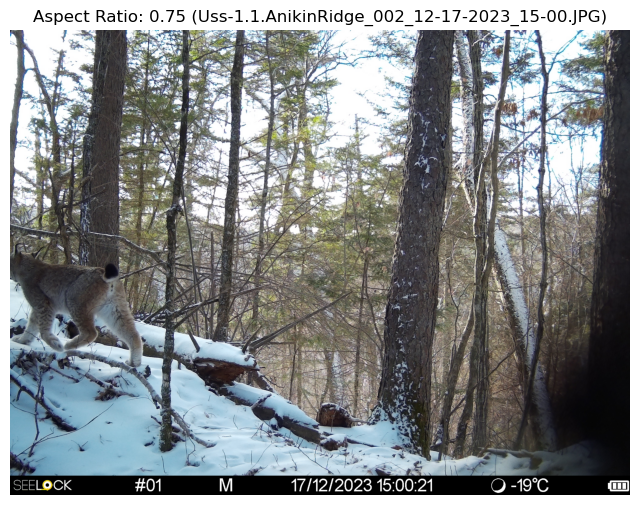

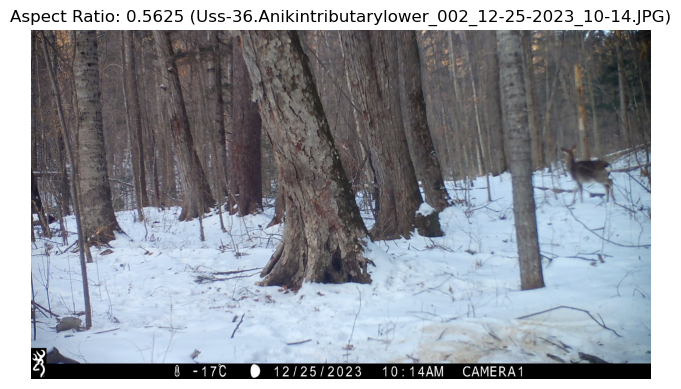

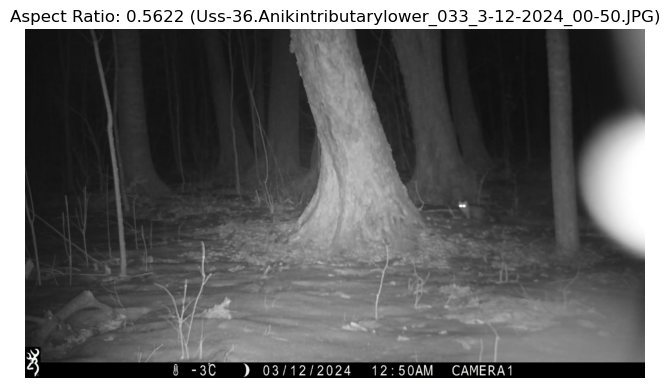

In [17]:
from collections import defaultdict

# Function to calculate the shape and return image file and aspect ratio
def img_shape_with_file(img_file):
    file_path = f'{IMGS_PATH}/{img_file}'
    img = cv2.imread(file_path)
    h, w, _ = img.shape
    aspect_ratio = round(h / w, 4)  # Calculate aspect ratio
    return img_file, aspect_ratio

# Use multiprocessing to process all images
%time
with multiprocessing.Pool(N_CORES) as pool:
    results = pool.map(img_shape_with_file, img_files)
    pool.close()
    pool.join()

# Create a dictionary to store one image for each unique aspect ratio
aspect_ratio_examples = {}
for img_file, aspect_ratio in results:
    if aspect_ratio not in aspect_ratio_examples:
        aspect_ratio_examples[aspect_ratio] = img_file
    # Stop if all aspect ratios are covered
    if len(aspect_ratio_examples) == len(set([r[1] for r in results])):
        break

# Display the selected images
for aspect_ratio, img_file in aspect_ratio_examples.items():
    file_path = f'{IMGS_PATH}/{img_file}'
    img = cv2.imread(file_path)
    plt.figure(figsize=(8, 8))
    plt.title(f"Aspect Ratio: {aspect_ratio} ({img_file})")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.axis('off')
    plt.show()

### Image File Size

Here we will:

- Analyze the file sizes of images to identify potential outliers (e.g., unusually large or small files that might need special handling).
- Useful to assess storage requirements and detect possible corrupt or low-quality images.

Min size: 130324 bytes, Max size: 2611214 bytes


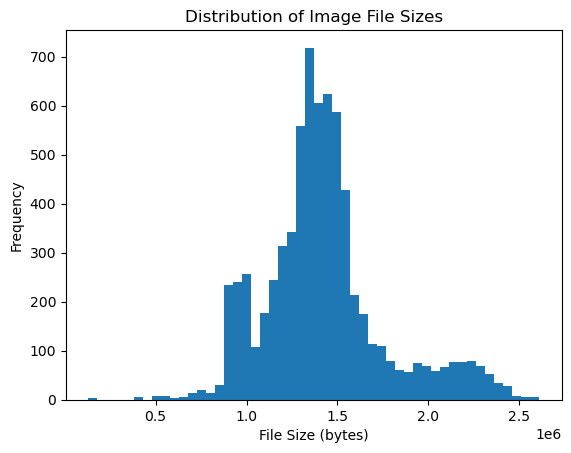

In [18]:
# Get file sizes
file_sizes = []
for img_file in img_files:
    file_path = f'{IMGS_PATH}/{img_file}'
    file_sizes.append(os.path.getsize(file_path))

# Analyze file sizes
print(f"Min size: {min(file_sizes)} bytes, Max size: {max(file_sizes)} bytes")
plt.hist(file_sizes, bins=50)
plt.title("Distribution of Image File Sizes")
plt.xlabel("File Size (bytes)")
plt.ylabel("Frequency")
plt.show()

### Corrupt or Incomplete Images

Here we will:

Identify and flag corrupt images that fail to load or have abnormal properties (e.g., missing channels or zero dimensions).

In [40]:
from multiprocessing import Pool

# Function to check if an image is corrupt
def check_image(img_file):
    file_path = f'{IMGS_PATH}/{img_file}'
    try:
        img = cv2.imread(file_path)
        if img is None or img.shape[0] == 0 or img.shape[1] == 0:
            return img_file 
    except Exception:
        return img_file  # Return the corrupt image file in case of an exception
    return None  # Return None if the image is not corrupt

# Use multiprocessing to check for corrupt images
if __name__ == '__main__':
    print("Checking for corrupt images...")
    with Pool(N_CORES) as pool:
        results = pool.map(check_image, img_files)
        pool.close()
        pool.join()

    # Filter out None values to get the list of corrupt images
    corrupt_images = [img_file for img_file in results if img_file is not None]

    # Print the results
    print(f"Number of corrupt images: {len(corrupt_images)}")
    if corrupt_images:
        print("Examples of corrupt images:", corrupt_images[:5])

Checking for corrupt images...
Number of corrupt images: 0


### Color Distribution
Here we will:
- Analyze the color channels (Red, Green, Blue) to check if images are balanced or if specific channels dominate.
- This can help detect issues like grayscale images mistakenly labeled as RGB.

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


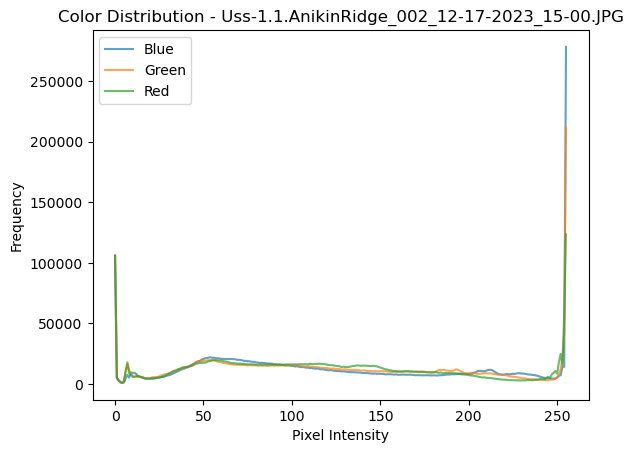

In [22]:
from multiprocessing import Pool

def analyze_color_distribution(img_file):
    """
    Analyze the color distribution of a single image.
    Returns the histogram data for Blue, Green, and Red channels.
    """
    file_path = f'{IMGS_PATH}/{img_file}'
    img = cv2.imread(file_path)
    if img is None:
        return None  # Handle corrupt or unreadable images
    histograms = {}
    colors = ['Blue', 'Green', 'Red']
    for i, color in enumerate(colors):
        histograms[color] = np.histogram(img[:, :, i].ravel(), bins=256, range=(0, 256))[0]
    return img_file, histograms

# Wrapper function to save and process all images in parallel
def process_all_images_color_distribution(img_files, n_cores):
    with Pool(n_cores) as pool:
        results = pool.map(analyze_color_distribution, img_files)
    return results

# Run the analysis with multiprocessing
%time
color_distributions = process_all_images_color_distribution(img_files, N_CORES)

# Filter out None results
color_distributions = [result for result in color_distributions if result is not None]

# Example of visualizing the histogram for one image
example_file, example_hist = color_distributions[0]
colors = ['Blue', 'Green', 'Red']
for color in colors:
    plt.plot(example_hist[color], label=color, alpha=0.7)
plt.title(f"Color Distribution - {example_file}")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()



# # Analyze color distribution
# for img_file in img_files[:5]:  # Process a sample of 5 images
#     file_path = f'{IMGS_PATH}/{img_file}'
#     img = cv2.imread(file_path)
#     colors = ['Blue', 'Green', 'Red']
#     for i, color in enumerate(colors):
#         plt.hist(img[:, :, i].ravel(), bins=256, color=color.lower(), alpha=0.5, label=color)
#     plt.title(f"Color Distribution - {img_file}")
#     plt.xlabel("Pixel Intensity")
#     plt.ylabel("Frequency")
#     plt.legend()
#     plt.show()


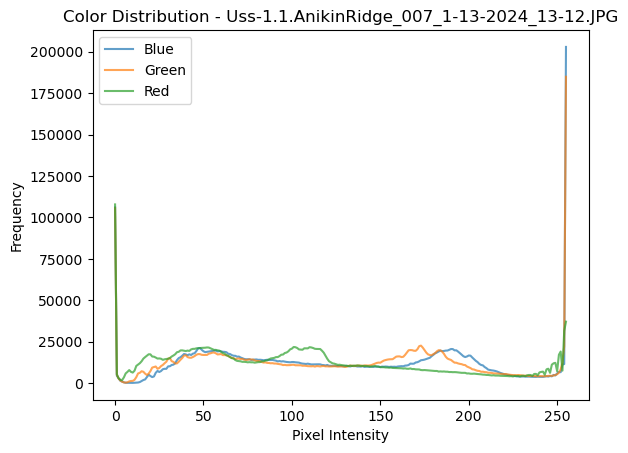

In [43]:
# Example of visualizing the histogram for one image
example_file, example_hist = color_distributions[5]
colors = ['Blue', 'Green', 'Red']
for color in colors:
    plt.plot(example_hist[color], label=color, alpha=0.7)
plt.title(f"Color Distribution - {example_file}")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Brightness and Contrast

Here we asses:

- Assess the brightness and contrast of images. Very dark or overly bright images may require adjustments for better recognition performance.

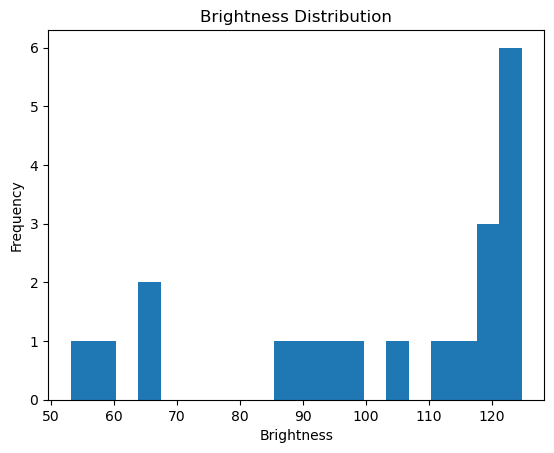

In [44]:
def calc_brightness(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray.mean()

brightness_values = []
for img_file in img_files[:20]:  # Process a sample of 20 images
    file_path = f'{IMGS_PATH}/{img_file}'
    img = cv2.imread(file_path)
    brightness_values.append(calc_brightness(img))

# Plot brightness distribution
plt.hist(brightness_values, bins=20)
plt.title("Brightness Distribution")
plt.xlabel("Brightness")
plt.ylabel("Frequency")
plt.show()

### Blurriness
Here we will 

Measure the sharpness or blurriness of the images. Blurry images may need to be excluded or enhanced for better recognition accuracy.


Histogram Peaks:

- A peak on the higher end of the x-axis suggests that most images in the sample are sharp and have a lot of edge details.
- A peak on the lower end suggests that many images are blurry.


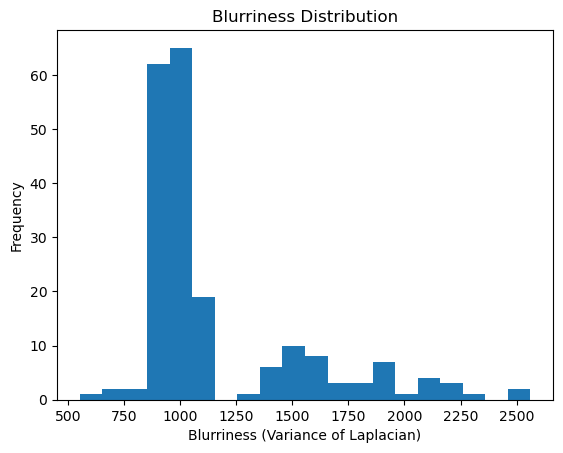

In [50]:
def calc_blurriness(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

blurriness_values = []
for img_file in img_files[:200]:  # Process a sample of 20 images
    file_path = f'{IMGS_PATH}/{img_file}'
    img = cv2.imread(file_path)
    blurriness_values.append(calc_blurriness(img))

plt.hist(blurriness_values, bins=20)
plt.title("Blurriness Distribution")
plt.xlabel("Blurriness (Variance of Laplacian)")
plt.ylabel("Frequency")
plt.show()

In [108]:
# Function to load API credentials from a file

def access_data(file_path):
    '''
    Reads credentials from file.

    '''
    with open(file_path) as file:
        access_data = json.load(file)
    return access_data

# Load Yandex OCR API credentials
CREDS = access_data(file_path='access_ya_api.json')
print(CREDS.keys())

dict_keys(['service_account_id', 'folder_id', 'key_id', 'secret_key'])


In [109]:
# Function to send an image to the Yandex OCR API and extract text

def ya_ocr(img):
    data = {
        'mimeType': 'JPEG',
        'languageCodes': ['en'],
        "model": "table",
        'content': base64.b64encode(img).decode('utf-8')
        #'content': img.tostring()
    }
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Api-Key {CREDS["secret_key"]}',
        'x-folder-id': CREDS['folder_id'],
        'x-data-logging-enabled': 'true'
    }
    r = requests.post(
        url=URL_OCR_SERVICE,
        headers=headers,
        data=json.dumps(data)
    )
    text = r.json()['result']['textAnnotation']['fullText']
    return text

In [55]:
# # Function to extract metadata from an image

# def img_metadata(img_file, th=1, plot=False):
#     meta = {}
#     meta['name'] = img_file
#     file_path = f'{IMGS_PATH}/{img_file}'
#     img = cv2.imread(file_path)
#     meta['shape'] = img.shape
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img_th = cv2.threshold(gray, th, 255, cv2.THRESH_BINARY)[1]
#     img_th = 255 - img_th
#     contours, _ = cv2.findContours(
#         img_th, 
#         cv2.RETR_EXTERNAL, 
#         cv2.CHAIN_APPROX_SIMPLE
#     )
#     contour = max(contours, key=cv2.contourArea)
#     x, y, w, h = cv2.boundingRect(contour)
#     img_crop = img[y:y + h, x:x + w, :]
#     if plot:
#         plt.figure(figsize=(16, 8))
#         plt.imshow(img_crop)
#         plt.show()
#     img_crop = Image.fromarray(img_crop, 'RGB')
#     buffer = BytesIO()
#     img_crop.save(buffer, format="JPEG")
#     img_crop = buffer.getvalue()
#     text = ya_ocr(img_crop)
#     meta['metadata'] = text.replace('\n', ' ').strip()
#     del img, gray, img_th, contours, img_crop
#     gc.collect()
#     return meta

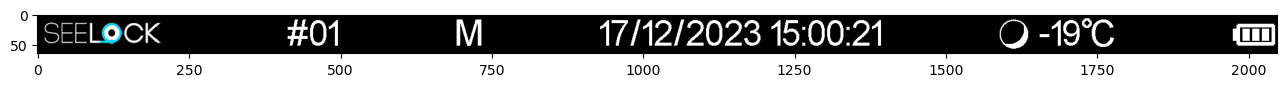

{'name': 'Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG',
 'shape': (1536, 2048, 3),
 'metadata': 'SEELOCK #01 M 17/12/2023 15:00:21 -19°C'}

In [56]:
# Test the metadata extraction function with plotting

img_metadata(img_files[0], plot=True)

In [70]:
import time
import shutil
import logging
from io import BytesIO
from PIL import Image

# Initialize logging
logging.basicConfig(filename="ocr_errors.log", level=logging.ERROR)

def ya_ocr_retry(img_crop, retries=5, delay=2):
    """
    Perform OCR with retries in case of rate-limiting errors.
    """
    for attempt in range(retries):
        try:
            text = ya_ocr(img_crop)
            if text is not None:
                return text
        except Exception as e:
            logging.error(f"OCR attempt {attempt + 1} failed: {str(e)}")
        time.sleep(delay * (2 ** attempt))  # Exponential backoff
    return None  # Return None after all retries fail

def img_metadata_with_logging(img_file, th=1, plot=False):
    """
    Extract metadata from an image and log problematic ones for further review.
    """
    meta = {}
    meta['name'] = img_file
    file_path = f'{IMGS_PATH}/{img_file}'
    img = cv2.imread(file_path)

    if img is None:
        meta['error'] = "Image could not be read"
        problematic_path = os.path.join(PROBLEMATIC_IMG_DIR, img_file)
        shutil.copy(file_path, problematic_path)
        return meta

    meta['shape'] = img.shape
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_th = cv2.threshold(gray, th, 255, cv2.THRESH_BINARY)[1]
    img_th = 255 - img_th
    contours, _ = cv2.findContours(
        img_th, 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    if not contours:  # Handle images with no contours
        meta['error'] = "No contours found"
        problematic_path = os.path.join(PROBLEMATIC_IMG_DIR, img_file)
        shutil.copy(file_path, problematic_path)
        return meta

    # Process contours if found
    contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(contour)
    img_crop = img[y:y + h, x:x + w, :]

    if plot:  # Optionally plot the cropped image
        plt.figure(figsize=(16, 8))
        plt.imshow(img_crop)
        plt.show()

    img_crop = Image.fromarray(img_crop, 'RGB')
    buffer = BytesIO()
    img_crop.save(buffer, format="JPEG")
    img_crop = buffer.getvalue()

    # Perform OCR with retries
    text = ya_ocr_retry(img_crop)
    if text is None:
        meta['error'] = "OCR failed"
        problematic_path = os.path.join(PROBLEMATIC_IMG_DIR, img_file)
        shutil.copy(file_path, problematic_path)
        return meta

    meta['metadata'] = text.replace('\n', ' ').strip()
    
    # Cleanup
    del img, gray, img_th, contours, img_crop
    gc.collect()
    return meta

In [74]:
from tqdm import tqdm
import time

metadata = []

# Batch processing with tqdm
batch_size = 10
for i in tqdm(range(0, len(img_files), batch_size), desc="Processing Batches"):
    batch = img_files[i:i + batch_size]
    
    for img_file in tqdm(batch, desc=f"Processing Images in Batch {i // batch_size + 1}", leave=False):
        result = process_image(img_file)
        metadata.append(result)
        time.sleep(2)  # Delay within batch

    time.sleep(10)  # Additional delay between batches


Processing Images in Batch 284:  40%|████      | 4/10 [00:14<00:21,  3.54s/it]

Error during OCR request: 503 Server Error: Service Unavailable for url: https://ocr.api.cloud.yandex.net/ocr/v1/recognizeText



Processing Images in Batch 334:  20%|██        | 2/10 [00:07<00:28,  3.57s/it]

Error during OCR request: 503 Server Error: Service Unavailable for url: https://ocr.api.cloud.yandex.net/ocr/v1/recognizeText



Processing Batches: 100%|██████████| 706/706 [9:01:42<00:00, 46.04s/it]      


In [75]:
print(len(metadata))
print(metadata[0])

7054
{'name': 'Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG', 'shape': (1536, 2048, 3), 'metadata': 'SEELOCK #01 M 17/12/2023 15:00:21 -19°C'}


In [133]:
# Convert the metadata list into a pandas DataFrame

df = pd.DataFrame(metadata)
df.head(20)

name            shape  \
0   Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG  (1536, 2048, 3)   
1   Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG  (1536, 2048, 3)   
2   Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG  (1536, 2048, 3)   
3   Uss-1.1.AnikinRidge_005_12-22-2023_15-41.JPG  (1536, 2048, 3)   
4     Uss-1.1.AnikinRidge_006_1-8-2024_19-13.JPG  (1536, 2048, 3)   
5    Uss-1.1.AnikinRidge_007_1-13-2024_13-12.JPG  (1536, 2048, 3)   
6    Uss-1.1.AnikinRidge_008_1-20-2024_15-10.JPG  (1536, 2048, 3)   
7    Uss-1.1.AnikinRidge_009_1-20-2024_15-55.JPG  (1536, 2048, 3)   
8    Uss-1.1.AnikinRidge_010_1-20-2024_15-59.JPG  (1536, 2048, 3)   
9    Uss-1.1.AnikinRidge_011_1-21-2024_13-39.JPG  (1536, 2048, 3)   
10   Uss-1.1.AnikinRidge_012_1-23-2024_18-09.JPG  (1536, 2048, 3)   
11   Uss-1.1.AnikinRidge_013_1-24-2024_10-12.JPG  (1536, 2048, 3)   
12   Uss-1.1.AnikinRidge_014_1-28-2024_02-11.JPG  (1536, 2048, 3)   
13   Uss-1.1.AnikinRidge_015_1-31-2024_02-33.JPG  (1536, 2048, 3)   
14    Uss-1.1.AnikinRidge_016_2-5-2024_02-02.JPG  (1536, 2048, 3)   
15   Uss-1.1.AnikinRidge_017_2-15-2024_16-12.JPG  (1536, 2048, 3)   
16   Uss-1.1.AnikinRidge_018_2-15-2024_16-12.JPG  (1536, 2048, 3)   
17   Uss-1.1.AnikinRidge_019_2-15-2024_16-12.JPG  (1536, 2048, 3)   
18   Uss-1.1.AnikinRidge_020_2-19-2024_05-15.JPG  (1536, 2048, 3)   
19   Uss-1.1.AnikinRidge_021_2-25-2024_16-27.JPG  (1536, 2048, 3)   

                                       metadata error  
0       SEELOCK #01 M 17/12/2023 15:00:21 -19°C   NaN  
1       SEELOCK #01 W 21/12/2023 09:22:24 -26°C   NaN  
2       SEELOCK #01 M 22/12/2023 15:40:26 -19°C   NaN  
3       SEELOCK #01 M 22/12/2023 15:41.12 -18°C   NaN  
4       SEELOCK #01 M 08/01/2024 19:13:17 -15°C   NaN  
5       SEELOCK #01 M 13/01/2024 13:12:30 -16°C   NaN  
6       SEELOCK #01 M 20/01/2024 15:10:12 -13°C   NaN  
7       SEELOCK #01 M 20/01/2024 15:55:27 -12°C   NaN  
8       SEELOCK #01 M 20/01/2024 15:59:46 -12°C   NaN  
9       SEELOCK #01 M 21/01/2024 13:39:46 -16°C   NaN  
10      SEELOCK #01 M 23/01/2024 18:09:40 -20°C   NaN  
11      SEELOCK #01 M 24/01/2024 10:12:41 -20°C   NaN  
12      SEELOCK #01 M 28/01/2024 02:11:44 -13°C   NaN  
13      SEELOCK #01 M 31/01/2024 02:33:34 -06°C   NaN  
14      SEELOCK #01 M 05/02/2024 02:02:34 -16°C   NaN  
15  SEELOCK #01 W 15/02/2024 16:12:09 -07°C 10]   NaN  
16      SEELOCK #01 M 15/02/2024 16:12:13 -07°C   NaN  
17      SEELOCK #01 M 15/02/2024 16:12:22 -07°C   NaN  
18      SEELOCK #01 M 19/02/2024 05:15:01 003°C   NaN  
19      SEELOCK #01 M 25/02/2024 16:27:44 -01°C   NaN

In [134]:
# Save the DataFrame to a CSV file for future use
output_csv = '/home/jovyan/Thesis/metadata.csv'
df.to_csv(output_csv, index=False)

#  save as a pickle file also for faster loading
output_pkl = '/home/jovyan/__ANIMALS/metadata.pkl'
df.to_pickle(output_pkl)

print(f"Metadata saved to {output_csv} and {output_pkl}")

Metadata saved to /home/jovyan/Thesis/metadata.csv and /home/jovyan/__ANIMALS/metadata.pkl


In [8]:
# Loading necesary libraries

import os
import gc
import cv2
import time
import json
import base64
import requests
import pytesseract
import multiprocessing
from io import BytesIO
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

# Metadata Loading and processing

### 1. Loading the Data

In [3]:
import pandas as pd

# Load metadata from saved files
df = pd.read_csv('metadata.csv')  

# Display initial information about the dataset
print(df.info())
df.tail(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7054 entries, 0 to 7053
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      7054 non-null   object
 1   shape     7054 non-null   object
 2   metadata  6915 non-null   object
 3   error     13 non-null     object
dtypes: object(4)
memory usage: 220.6+ KB
None


name            shape  \
7049   Uss-9.Peishula_034_4-4-2024_00-52.JPG  (1536, 2048, 3)   
7050   Uss-9.Peishula_035_4-4-2024_20-35.JPG  (1536, 2048, 3)   
7051   Uss-9.Peishula_036_4-9-2024_23-39.JPG  (1536, 2048, 3)   
7052  Uss-9.Peishula_037_4-10-2024_19-03.JPG  (1536, 2048, 3)   
7053  Uss-9.Peishula_038_4-11-2024_19-29.JPG  (1536, 2048, 3)   

                                     metadata error  
7049  SEELOCK #01 M 04/04/2024 00:52:06 002°C   NaN  
7050  SEELOCK #01 M 04/04/2024 20:35:13 005°C   NaN  
7051  SEELOCK #01 M 09/04/2024 23:39:56 -01°C   NaN  
7052  SEELOCk #01 M 10/04/2024 19:03:28 006°C   NaN  
7053  SEELOCK #01 M 11/04/2024 19:29:52 011°C   NaN

### Images with no metadata

In [4]:
# Separate rows where error is 'No contours found' into a separate DataFrame
df_no_metadata = df[df['error'] == 'No contours found']

# Save rows with no metadata to a separate CSV file (optional)
df_no_metadata.to_csv('no_metadata_images.csv', index=False)
print(f"Saved {len(df_no_metadata)} images with no metadata to 'no_metadata_images.csv'")

# Exclude rows where error is 'No contours found' from the main DataFrame
df = df[df['error'] != 'No contours found']

# Display the updated DataFrame info
print(f"Number of remaining images: {len(df)}")
print(df.head())

# Save the updated main DataFrame
df.to_csv('metadata_updated.csv', index=False)
print("Updated DataFrame saved to 'metadata_updated.csv'")


Saved 13 images with no metadata to 'no_metadata_images.csv'
Number of remaining images: 7041
                                           name            shape  \
0  Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG  (1536, 2048, 3)   
1  Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG  (1536, 2048, 3)   
2  Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG  (1536, 2048, 3)   
3  Uss-1.1.AnikinRidge_005_12-22-2023_15-41.JPG  (1536, 2048, 3)   
4    Uss-1.1.AnikinRidge_006_1-8-2024_19-13.JPG  (1536, 2048, 3)   

                                  metadata error  
0  SEELOCK #01 M 17/12/2023 15:00:21 -19°C   NaN  
1  SEELOCK #01 W 21/12/2023 09:22:24 -26°C   NaN  
2  SEELOCK #01 M 22/12/2023 15:40:26 -19°C   NaN  
3  SEELOCK #01 M 22/12/2023 15:41.12 -18°C   NaN  
4  SEELOCK #01 M 08/01/2024 19:13:17 -15°C   NaN  
Updated DataFrame saved to 'metadata_updated.csv'


In [9]:
df.head(5)

name            shape  \
0  Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG  (1536, 2048, 3)   
1  Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG  (1536, 2048, 3)   
2  Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG  (1536, 2048, 3)   
3  Uss-1.1.AnikinRidge_005_12-22-2023_15-41.JPG  (1536, 2048, 3)   
4    Uss-1.1.AnikinRidge_006_1-8-2024_19-13.JPG  (1536, 2048, 3)   

                                  metadata error  
0  SEELOCK #01 M 17/12/2023 15:00:21 -19°C   NaN  
1  SEELOCK #01 W 21/12/2023 09:22:24 -26°C   NaN  
2  SEELOCK #01 M 22/12/2023 15:40:26 -19°C   NaN  
3  SEELOCK #01 M 22/12/2023 15:41.12 -18°C   NaN  
4  SEELOCK #01 M 08/01/2024 19:13:17 -15°C   NaN

### Plot images with no metadata

In [10]:
df_no_metadata.head(5)

name            shape  metadata  \
0      Uss-33.1.Dubovaya_004_2-1-2024_18-47.JPG  (1944, 2592, 3)       NaN   
1  Uss-61.Komarovkarock_014_1-14-2024_23-23.JPG  (1080, 1920, 3)       NaN   
2  Uss-61.Komarovkarock_015_1-14-2024_23-23.JPG  (1080, 1920, 3)       NaN   
3  Uss-61.Komarovkarock_029_1-23-2024_21-59.JPG  (1080, 1920, 3)       NaN   
4  Uss-61.Komarovkarock_030_1-23-2024_21-59.JPG  (1080, 1920, 3)       NaN   

               error  
0  No contours found  
1  No contours found  
2  No contours found  
3  No contours found  
4  No contours found

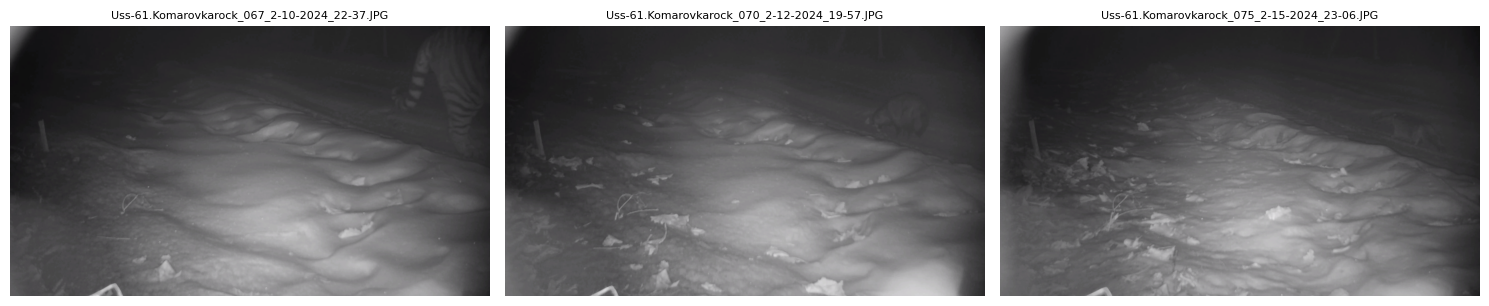

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2  # OpenCV for reading images

# Load the DataFrame with no metadata
df_no_metadata = pd.read_csv('no_metadata_images.csv')

# Function to display images based on indexing
def plot_images(df, index_range, image_folder):
    """
    Plots images from the given DataFrame within the specified index range.
    
    Args:
        df (pd.DataFrame): DataFrame containing image file names.
        index_range (tuple): Tuple specifying the range of indices (start, end).
        image_folder (str): Path to the folder containing the images.
    """
    start, end = index_range
    selected_images = df.iloc[start:end]

    # Plot images
    fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 5))
    if len(selected_images) == 1:
        axes = [axes]  # Ensure axes is always a list

    for ax, (_, row) in zip(axes, selected_images.iterrows()):
        image_path = f"{image_folder}/{row['name']}"
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
            ax.imshow(image)
            ax.set_title(row['name'], fontsize=8)
        else:
            ax.set_title(f"Image not found: {row['name']}", fontsize=8)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


image_folder = '/home/jovyan/__ANIMALS/images'

# Plot images with no metadata, e.g., from index 10 to 4
plot_images(df_no_metadata, index_range=(10, 14), image_folder=image_folder)


In [12]:
df.error.unique()

array([nan], dtype=object)

### 3. Extracting Date, Time, and Temperature

In [13]:
import pandas as pd
import re

# Load the updated metadata DataFrame
df = pd.read_csv('metadata_updated.csv')

# Example function to clean metadata string
def clean_metadata(metadata):
    # Replace common inconsistencies
    metadata = metadata.replace("::", ":").replace("°°", "°").replace("°C", "C").replace("°°°", "°")
    return metadata.strip()

# Define regex patterns for date, time, and temperature
date_patterns = [
    r"(\d{2}/\d{2}/\d{4})",  # DD/MM/YYYY
    r"(\d{2}-\d{2}-\d{4})",  # DD-MM-YYYY
    r"(\d{1}/\d{1,2}/\d{4})",  # M/DD/YYYY
    r"(\d{1,2}/\d{1,2}/\d{4})",  # MM/DD/YYYY or M/D/YYYY
]

time_patterns = [
    r"(\d{2}:\d{2}:\d{2})",  # HH:MM:SS
    r"(\d{2}:\d{2})",        # HH:MM
    r"(\d{2}:\d{2}[AP]M)",  # HH:MMAM/PM
]

temperature_patterns = [
    r"([-+]?\d{1,3}C)",      # e.g., -18C, +10C
    r"([-+]?\d{1,3}°C)",     # e.g., -18°C
    r"([-+]?\d{1,3}°)",      # e.g., -18°
]

def extract_metadata_components(metadata):
    """
    Extracts date, time, and temperature from the metadata string.

    Args:
        metadata (str): Metadata string.

    Returns:
        tuple: Extracted date, time, and temperature.
    """
    if pd.isna(metadata):  # Handle missing metadata
        return None, None, None

    metadata = clean_metadata(metadata)

    date, time, temp = None, None, None

    for pattern in date_patterns:
        date_match = re.search(pattern, metadata)
        if date_match:
            date = date_match.group(1)
            break

    for pattern in time_patterns:
        time_match = re.search(pattern, metadata)
        if time_match:
            time = time_match.group(1)
            break

    for pattern in temperature_patterns:
        temp_match = re.search(pattern, metadata)
        if temp_match:
            temp = temp_match.group(1)
            break

    return date, time, temp

# Apply the function to extract components
df[['date', 'time', 'temperature']] = df['metadata'].apply(
    lambda x: pd.Series(extract_metadata_components(x))
)

# Save rows with missing or erroneous metadata to a new DataFrame
df_partial_metadata = df[
    (df['date'].isna()) | (df['time'].isna()) | (df['temperature'].isna())
]

# Save rows with partial or missing metadata for investigation
df_partial_metadata.to_csv('partial_metadata_images.csv', index=False)
print(f"Saved {len(df_partial_metadata)} rows with partial/missing metadata to 'partial_metadata_images.csv'")

# Display the DataFrame with the extracted components for verification
df.head()

Saved 188 rows with partial/missing metadata to 'partial_metadata_images.csv'


name            shape  \
0  Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG  (1536, 2048, 3)   
1  Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG  (1536, 2048, 3)   
2  Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG  (1536, 2048, 3)   
3  Uss-1.1.AnikinRidge_005_12-22-2023_15-41.JPG  (1536, 2048, 3)   
4    Uss-1.1.AnikinRidge_006_1-8-2024_19-13.JPG  (1536, 2048, 3)   

                                  metadata  error        date      time  \
0  SEELOCK #01 M 17/12/2023 15:00:21 -19°C    NaN  17/12/2023  15:00:21   
1  SEELOCK #01 W 21/12/2023 09:22:24 -26°C    NaN  21/12/2023  09:22:24   
2  SEELOCK #01 M 22/12/2023 15:40:26 -19°C    NaN  22/12/2023  15:40:26   
3  SEELOCK #01 M 22/12/2023 15:41.12 -18°C    NaN  22/12/2023     15:41   
4  SEELOCK #01 M 08/01/2024 19:13:17 -15°C    NaN  08/01/2024  19:13:17   

  temperature  
0        -19C  
1        -26C  
2        -19C  
3        -18C  
4        -15C

In [14]:
df.tail(10)

name            shape  \
7031  Uss-9.Peishula_029_3-16-2024_23-53.JPG  (1536, 2048, 3)   
7032  Uss-9.Peishula_030_3-24-2024_19-15.JPG  (1536, 2048, 3)   
7033  Uss-9.Peishula_031_3-26-2024_02-25.JPG  (1536, 2048, 3)   
7034  Uss-9.Peishula_032_3-31-2024_21-46.JPG  (1536, 2048, 3)   
7035   Uss-9.Peishula_033_4-1-2024_21-48.JPG  (1536, 2048, 3)   
7036   Uss-9.Peishula_034_4-4-2024_00-52.JPG  (1536, 2048, 3)   
7037   Uss-9.Peishula_035_4-4-2024_20-35.JPG  (1536, 2048, 3)   
7038   Uss-9.Peishula_036_4-9-2024_23-39.JPG  (1536, 2048, 3)   
7039  Uss-9.Peishula_037_4-10-2024_19-03.JPG  (1536, 2048, 3)   
7040  Uss-9.Peishula_038_4-11-2024_19-29.JPG  (1536, 2048, 3)   

                                     metadata  error        date      time  \
7031  SEELOCK #01 M 16/03/2024 23:53:34 001°C    NaN  16/03/2024  23:53:34   
7032  SEELOCK #01 M 24/03/2024 19:15:25 004°C    NaN  24/03/2024  19:15:25   
7033  SEELOCK #01 M 26/03/2024 02:25:25 -01°C    NaN  26/03/2024  02:25:25   
7034  SEELOCK #01 M 31/03/2024 21:46:28 000°C    NaN  31/03/2024  21:46:28   
7035  SEELOCK #01 M 01/04/2024 21:48:06 000°C    NaN  01/04/2024  21:48:06   
7036  SEELOCK #01 M 04/04/2024 00:52:06 002°C    NaN  04/04/2024  00:52:06   
7037  SEELOCK #01 M 04/04/2024 20:35:13 005°C    NaN  04/04/2024  20:35:13   
7038  SEELOCK #01 M 09/04/2024 23:39:56 -01°C    NaN  09/04/2024  23:39:56   
7039  SEELOCk #01 M 10/04/2024 19:03:28 006°C    NaN  10/04/2024  19:03:28   
7040  SEELOCK #01 M 11/04/2024 19:29:52 011°C    NaN  11/04/2024  19:29:52   

     temperature  
7031        001C  
7032        004C  
7033        -01C  
7034        000C  
7035        000C  
7036        002C  
7037        005C  
7038        -01C  
7039        006C  
7040        011C

### Filter out the metadata with errors

In [15]:
df_clean = df[
    ~(df['date'].isna()) & ~(df['time'].isna()) & ~(df['temperature'].isna())
].copy()

In [16]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6853 entries, 0 to 7040
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         6853 non-null   object 
 1   shape        6853 non-null   object 
 2   metadata     6853 non-null   object 
 3   error        0 non-null      float64
 4   date         6853 non-null   object 
 5   time         6853 non-null   object 
 6   temperature  6853 non-null   object 
dtypes: float64(1), object(6)
memory usage: 428.3+ KB


In [17]:
df_clean.head(10)

name            shape  \
0  Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG  (1536, 2048, 3)   
1  Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG  (1536, 2048, 3)   
2  Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG  (1536, 2048, 3)   
3  Uss-1.1.AnikinRidge_005_12-22-2023_15-41.JPG  (1536, 2048, 3)   
4    Uss-1.1.AnikinRidge_006_1-8-2024_19-13.JPG  (1536, 2048, 3)   
5   Uss-1.1.AnikinRidge_007_1-13-2024_13-12.JPG  (1536, 2048, 3)   
6   Uss-1.1.AnikinRidge_008_1-20-2024_15-10.JPG  (1536, 2048, 3)   
7   Uss-1.1.AnikinRidge_009_1-20-2024_15-55.JPG  (1536, 2048, 3)   
8   Uss-1.1.AnikinRidge_010_1-20-2024_15-59.JPG  (1536, 2048, 3)   
9   Uss-1.1.AnikinRidge_011_1-21-2024_13-39.JPG  (1536, 2048, 3)   

                                  metadata  error        date      time  \
0  SEELOCK #01 M 17/12/2023 15:00:21 -19°C    NaN  17/12/2023  15:00:21   
1  SEELOCK #01 W 21/12/2023 09:22:24 -26°C    NaN  21/12/2023  09:22:24   
2  SEELOCK #01 M 22/12/2023 15:40:26 -19°C    NaN  22/12/2023  15:40:26   
3  SEELOCK #01 M 22/12/2023 15:41.12 -18°C    NaN  22/12/2023     15:41   
4  SEELOCK #01 M 08/01/2024 19:13:17 -15°C    NaN  08/01/2024  19:13:17   
5  SEELOCK #01 M 13/01/2024 13:12:30 -16°C    NaN  13/01/2024  13:12:30   
6  SEELOCK #01 M 20/01/2024 15:10:12 -13°C    NaN  20/01/2024  15:10:12   
7  SEELOCK #01 M 20/01/2024 15:55:27 -12°C    NaN  20/01/2024  15:55:27   
8  SEELOCK #01 M 20/01/2024 15:59:46 -12°C    NaN  20/01/2024  15:59:46   
9  SEELOCK #01 M 21/01/2024 13:39:46 -16°C    NaN  21/01/2024  13:39:46   

  temperature  
0        -19C  
1        -26C  
2        -19C  
3        -18C  
4        -15C  
5        -16C  
6        -13C  
7        -12C  
8        -12C  
9        -16C

In [18]:
df_clean.tail(10)

name            shape  \
7031  Uss-9.Peishula_029_3-16-2024_23-53.JPG  (1536, 2048, 3)   
7032  Uss-9.Peishula_030_3-24-2024_19-15.JPG  (1536, 2048, 3)   
7033  Uss-9.Peishula_031_3-26-2024_02-25.JPG  (1536, 2048, 3)   
7034  Uss-9.Peishula_032_3-31-2024_21-46.JPG  (1536, 2048, 3)   
7035   Uss-9.Peishula_033_4-1-2024_21-48.JPG  (1536, 2048, 3)   
7036   Uss-9.Peishula_034_4-4-2024_00-52.JPG  (1536, 2048, 3)   
7037   Uss-9.Peishula_035_4-4-2024_20-35.JPG  (1536, 2048, 3)   
7038   Uss-9.Peishula_036_4-9-2024_23-39.JPG  (1536, 2048, 3)   
7039  Uss-9.Peishula_037_4-10-2024_19-03.JPG  (1536, 2048, 3)   
7040  Uss-9.Peishula_038_4-11-2024_19-29.JPG  (1536, 2048, 3)   

                                     metadata  error        date      time  \
7031  SEELOCK #01 M 16/03/2024 23:53:34 001°C    NaN  16/03/2024  23:53:34   
7032  SEELOCK #01 M 24/03/2024 19:15:25 004°C    NaN  24/03/2024  19:15:25   
7033  SEELOCK #01 M 26/03/2024 02:25:25 -01°C    NaN  26/03/2024  02:25:25   
7034  SEELOCK #01 M 31/03/2024 21:46:28 000°C    NaN  31/03/2024  21:46:28   
7035  SEELOCK #01 M 01/04/2024 21:48:06 000°C    NaN  01/04/2024  21:48:06   
7036  SEELOCK #01 M 04/04/2024 00:52:06 002°C    NaN  04/04/2024  00:52:06   
7037  SEELOCK #01 M 04/04/2024 20:35:13 005°C    NaN  04/04/2024  20:35:13   
7038  SEELOCK #01 M 09/04/2024 23:39:56 -01°C    NaN  09/04/2024  23:39:56   
7039  SEELOCk #01 M 10/04/2024 19:03:28 006°C    NaN  10/04/2024  19:03:28   
7040  SEELOCK #01 M 11/04/2024 19:29:52 011°C    NaN  11/04/2024  19:29:52   

     temperature  
7031        001C  
7032        004C  
7033        -01C  
7034        000C  
7035        000C  
7036        002C  
7037        005C  
7038        -01C  
7039        006C  
7040        011C

### It looks like there are some inconsistencies in the data extracted from the metadata column hence I will work on that.

In [19]:
# Function to standardize date format
def standardize_date(date_str):
    if pd.isna(date_str):
        return None
    try:
        return pd.to_datetime(date_str, dayfirst=True).strftime('%d/%m/%Y')  # Assuming DD/MM/YYYY format
    except:
        return None

# Function to standardize time format
def standardize_time(time_str):
    if pd.isna(time_str):
        return None
    try:
        return pd.to_datetime(time_str).strftime('%H:%M:%S')  # Assuming 24-hour format
    except:
        return None

# Function to standardize temperature format
def standardize_temperature(temp_str):
    if pd.isna(temp_str):
        return None
    temp_str = temp_str.replace('°C', '').replace('C', '')  # Remove unnecessary characters
    try:
        return str(int(temp_str))  # Convert to integer and back to string
    except:
        return None

# Apply standardization functions
df_clean['date'] = df_clean['date'].apply(standardize_date)
df_clean['time'] = df_clean['time'].apply(standardize_time)
df_clean['temperature'] = df_clean['temperature'].apply(standardize_temperature)

/tmp/ipykernel_4258/3385437553.py:6: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(date_str, dayfirst=True).strftime('%d/%m/%Y')  # Assuming DD/MM/YYYY format


In [20]:
df_clean.head()

name            shape  \
0  Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG  (1536, 2048, 3)   
1  Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG  (1536, 2048, 3)   
2  Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG  (1536, 2048, 3)   
3  Uss-1.1.AnikinRidge_005_12-22-2023_15-41.JPG  (1536, 2048, 3)   
4    Uss-1.1.AnikinRidge_006_1-8-2024_19-13.JPG  (1536, 2048, 3)   

                                  metadata  error        date      time  \
0  SEELOCK #01 M 17/12/2023 15:00:21 -19°C    NaN  17/12/2023  15:00:21   
1  SEELOCK #01 W 21/12/2023 09:22:24 -26°C    NaN  21/12/2023  09:22:24   
2  SEELOCK #01 M 22/12/2023 15:40:26 -19°C    NaN  22/12/2023  15:40:26   
3  SEELOCK #01 M 22/12/2023 15:41.12 -18°C    NaN  22/12/2023  15:41:00   
4  SEELOCK #01 M 08/01/2024 19:13:17 -15°C    NaN  08/01/2024  19:13:17   

  temperature  
0         -19  
1         -26  
2         -19  
3         -18  
4         -15

### Check if dates are in the same format

In [21]:
#Function to check for MM/DD/YYYY format
def check_date_format(date_str):
    if pd.isna(date_str):
        return False
    try:
        # Attempt to parse with dayfirst=True (DD/MM/YYYY)
        pd.to_datetime(date_str, dayfirst=True)  # Use dayfirst=True for DD/MM/YYYY
        return True  # If successful, it's likely DD/MM/YYYY
    except:
        try:
            # If parsing with dayfirst=True fails, try dayfirst=False (MM/DD/YYYY)
            pd.to_datetime(date_str, dayfirst=False)
            return False  # If successful with dayfirst=False, it's MM/DD/YYYY
        except:
            return None  # If both fail, the date format is invalid

# Check for inconsistent date formats in the extracted 'date' column
inconsistent_dates = df_clean[df_clean['date'].apply(lambda x: check_date_format(x) == False)]

if len(inconsistent_dates) > 0:
    print("WARNING: Inconsistent date formats found!")
    print(inconsistent_dates)
    # Handle inconsistent dates (e.g., manually correct them or adjust standardization)
else:
    print("All dates are in the DD/MM/YYYY format.")

All dates are in the DD/MM/YYYY format.


### Working on the partial extracted or errorneous metadata

In [22]:
df_partial_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188 entries, 1738 to 6642
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         188 non-null    object 
 1   shape        188 non-null    object 
 2   metadata     62 non-null     object 
 3   error        0 non-null      float64
 4   date         16 non-null     object 
 5   time         44 non-null     object 
 6   temperature  21 non-null     object 
dtypes: float64(1), object(6)
memory usage: 11.8+ KB


In [23]:
df_partial_metadata.head(10)

name            shape  \
1738      Uss-2.1.PetrovskyPass_537_2-17-2024_14-02.JPG  (1536, 2048, 3)   
3749      Uss-31.1.Bogolyubovka_006_1-15-2024_14-47.JPG  (1944, 2592, 3)   
3771       Uss-31.1.Bogolyubovka_030_4-7-2024_07-16.JPG  (1944, 2592, 3)   
3844         Uss-33.1.Dubovaya_002_12-23-2023_09-11.JPG  (1944, 2592, 3)   
3845         Uss-33.1.Dubovaya_003_12-31-2023_18-54.JPG  (1944, 2592, 3)   
3846           Uss-33.1.Dubovaya_005_2-2-2024_01-33.JPG  (1944, 2592, 3)   
3847           Uss-33.1.Dubovaya_006_2-5-2024_10-38.JPG  (1944, 2592, 3)   
3990     Uss-35.Anikintributary_021_4-17-2024_09-51.JPG  (1536, 2048, 3)   
3992  Uss-36.Anikintributarylower_002_12-25-2023_10-...  (1080, 1920, 3)   
3993  Uss-36.Anikintributarylower_003_12-26-2023_12-...  (1080, 1920, 3)   

                                       metadata  error        date      time  \
1738  SEELOCK #01 M 17/02/2024 14:02:36 800 10]    NaN  17/02/2024  14:02:36   
3749             220- EtiLt:tl t202/10/S1 W 10#    NaN        None      None   
3771      SEELOCK #01 M 07/04/2024 07:16:52 005    NaN  07/04/2024  07:16:52   
3844                                        NaN    NaN        None      None   
3845                                        NaN    NaN        None      None   
3846                                        NaN    NaN        None      None   
3847                                        NaN    NaN        None      None   
3990  SEELOCK #01 M 17/04/2024 09:51:46 800 10]    NaN  17/04/2024  09:51:46   
3992          - 17C 12/25 /2023 10:14AM CAMERA1    NaN        None     10:14   
3993           -10C12/ 26 /2023 12:05PM CAMERA1    NaN        None     12:05   

     temperature  
1738        None  
3749        None  
3771        None  
3844        None  
3845        None  
3846        None  
3847        None  
3990        None  
3992         17C  
3993        -10C

### So from the observation, it looks like there were mainly two types of cameras used. one from sleeock and the other one from camera1. 
### However, the extracted metadata from 19 of the the sleelock images have a little issues extracting the data rightly, hence I will fix these errors below

In [24]:
# Filter partial metadata for entries containing "SEELOCK"
df_partial_seelock = df_partial_metadata[
    df_partial_metadata['metadata'].str.contains("SEELOCK", na=False)
]

# Display the filtered DataFrame
print("\nPartial Metadata DataFrame (SEELOCK):")
print(df_partial_seelock.info())
df_partial_seelock.head(19)


Partial Metadata DataFrame (SEELOCK):
<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 1738 to 6642
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         19 non-null     object 
 1   shape        19 non-null     object 
 2   metadata     19 non-null     object 
 3   error        0 non-null      float64
 4   date         13 non-null     object 
 5   time         12 non-null     object 
 6   temperature  0 non-null      object 
dtypes: float64(1), object(6)
memory usage: 1.2+ KB
None


name            shape  \
1738      Uss-2.1.PetrovskyPass_537_2-17-2024_14-02.JPG  (1536, 2048, 3)   
3771       Uss-31.1.Bogolyubovka_030_4-7-2024_07-16.JPG  (1944, 2592, 3)   
3990     Uss-35.Anikintributary_021_4-17-2024_09-51.JPG  (1536, 2048, 3)   
4105         Uss-37.1.Vershinka_074_4-17-2024_09-25.JPG  (1536, 2048, 3)   
4299    Uss-39.1.Rakovkacrossing_442_4-4-2024_15-21.JPG  (1944, 2592, 3)   
4300    Uss-39.1.Rakovkacrossing_443_4-4-2024_15-21.JPG  (1944, 2592, 3)   
4762  Uss-40.1.Rakovka-MalayaRakovka_410_3-28-2024_1...  (1944, 2592, 3)   
4783  Uss-40.1.Rakovka-MalayaRakovka_436_4-12-2024_1...  (1944, 2592, 3)   
4786  Uss-40.1.Rakovka-MalayaRakovka_439_4-16-2024_1...  (1944, 2592, 3)   
5050     Uss-41.1.MalayaRakovka_154_3-22-2024_09-07.JPG  (1944, 2592, 3)   
5065     Uss-41.1.MalayaRakovka_169_3-26-2024_17-25.JPG  (1944, 2592, 3)   
5599            Uss-44.Lyapunov_023_3-15-2024_18-21.JPG  (1536, 2048, 3)   
6233         Uss-58.1.Vershinka_019_2-26-2024_18-48.JPG  (1944, 2592, 3)   
6575            Uss-62.Komarovka_345_3-9-2024_08-56.JPG  (1944, 2592, 3)   
6604            Uss-62.Komarovka_374_3-9-2024_08-58.JPG  (1944, 2592, 3)   
6608            Uss-62.Komarovka_378_3-9-2024_08-58.JPG  (1944, 2592, 3)   
6633           Uss-62.Komarovka_434_3-24-2024_07-23.JPG  (1944, 2592, 3)   
6639           Uss-62.Komarovka_440_3-24-2024_07-23.JPG  (1944, 2592, 3)   
6642           Uss-62.Komarovka_443_3-24-2024_07-23.JPG  (1944, 2592, 3)   

                                       metadata  error        date      time  \
1738  SEELOCK #01 M 17/02/2024 14:02:36 800 10]    NaN  17/02/2024  14:02:36   
3771      SEELOCK #01 M 07/04/2024 07:16:52 005    NaN  07/04/2024  07:16:52   
3990  SEELOCK #01 M 17/04/2024 09:51:46 800 10]    NaN  17/04/2024  09:51:46   
4105  SEELOCK #01 M 17/04/2024 09:25:41 800 10]    NaN  17/04/2024  09:25:41   
4299                              SEELOCK #01 M    NaN        None      None   
4300                              SEELOCK #01 M    NaN        None      None   
4762      SEELOCK #01 M 28/03/2024 18:45:29 005    NaN  28/03/2024  18:45:29   
4783           SEELOCK #01 M 12/04/2024 19:36:5    NaN  12/04/2024     19:36   
4786                          SEELOCK #01 M 16/    NaN        None      None   
5050                        SEELOCK #01 M 22/03    NaN        None      None   
5065      SEELOCK #01 M 26/03/2024 17:25:45 800    NaN  26/03/2024  17:25:45   
5599      SEELOCK #01 W 15/03/2024 18:21:17 800    NaN  15/03/2024  18:21:17   
6233                 SEELOCK #01 M 26/02/2023 1    NaN  26/02/2023      None   
6575                      SEELOCK #01 M 10/03/2    NaN        None      None   
6604                      SEELOCK #01 W 10/03/2    NaN        None      None   
6608      SEELOCK #01 M 10/03/2023 08:58:45 -13    NaN  10/03/2023  08:58:45   
6633      SEELOCK #01 M 24/03/2024 07:23:09 -01    NaN  24/03/2024  07:23:09   
6639      SEELOCK #01 M 24/03/2024 07:23:13 -01    NaN  24/03/2024  07:23:13   
6642      SEELOCK #01 M 24/03/2024 07:23:18 -01    NaN  24/03/2024  07:23:18   

     temperature  
1738        None  
3771        None  
3990        None  
4105        None  
4299        None  
4300        None  
4762        None  
4783        None  
4786        None  
5050        None  
5065        None  
5599        None  
6233        None  
6575        None  
6604        None  
6608        None  
6633        None  
6639        None  
6642        None

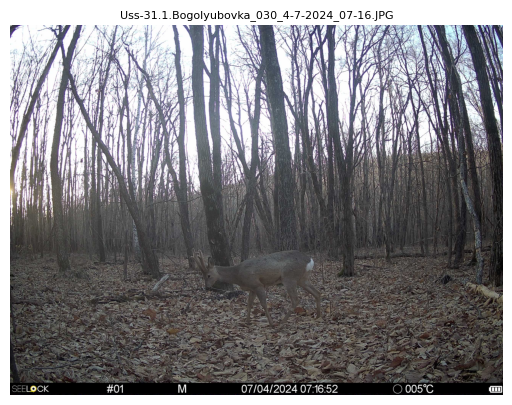

In [25]:
# Function to display images based on indexing (modified for single images)
def plot_image(df, index, image_folder):
    """
    Plots a single image from the given DataFrame at the specified index.

    Args:
        df (pd.DataFrame): DataFrame containing image file names.
        index (int): Index of the image to plot.
        image_folder (str): Path to the folder containing the images.
    """
    row = df.iloc[index]
    image_path = f"{image_folder}/{row['name']}"
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        plt.imshow(image)
        plt.title(row['name'], fontsize=8)
    else:
        plt.title(f"Image not found: {row['name']}", fontsize=8)
    plt.axis('off')
    plt.show()


image_folder = '/home/jovyan/__ANIMALS/images' 
plot_image(df_partial_seelock, index=1, image_folder=image_folder)

In [26]:
# Manually correct errors in df_partial_seelock based on visual inspection (using actual indices)
corrections = {
    1738: {'temperature': '8'},
    3771: {'temperature': '5'},
    3990: {'temperature': '8'},
    4105: {'temperature': '8'},
    4299: {'date': '04/04/2024', 'time': '15:21:28', 'temperature': '10'},
    4300: {'date': '04/04/2024', 'time': '15:21:36', 'temperature': '10'},
    4762: {'temperature': '5'},
    4783: {'time': '19:36:56', 'temperature': '14'},
    4786: {'date': '16/04/2024', 'time': '17:24:20', 'temperature': '13'},
    5050: {'date': '22/03/2024', 'time': '09:07:30', 'temperature': '-6'},
    5065: {'temperature': '8'},
    5599: {'temperature': '8'},
    6233: {'time': '18:48:28', 'temperature': '-4'},
    6575: {'date': '10/03/2023', 'time': '08:56:09', 'temperature': '-14'},
    6604: {'date': '10/03/2023', 'time': '08:58:09', 'temperature': '-14'},
    6608: {'temperature': '-13'},
    6633: {'temperature': '-1'},
    6639: {'temperature': '-1'},
    6642: {'temperature': '-1'},
}

for index, values in corrections.items():
    for col, value in values.items():
        df_partial_seelock.loc[df_partial_seelock.index == index, col] = value  # Use actual index

# Apply standardization functions
df_partial_seelock['date'] = df_partial_seelock['date'].apply(standardize_date)
df_partial_seelock['time'] = df_partial_seelock['time'].apply(standardize_time)
df_partial_seelock['temperature'] = df_partial_seelock['temperature'].apply(standardize_temperature)

# Display the corrected DataFrame
print("\nCorrected Partial Metadata DataFrame (SEELOCK):")
print(df_partial_seelock.info())
df_partial_seelock.head(19)


Corrected Partial Metadata DataFrame (SEELOCK):
<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 1738 to 6642
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         19 non-null     object 
 1   shape        19 non-null     object 
 2   metadata     19 non-null     object 
 3   error        0 non-null      float64
 4   date         19 non-null     object 
 5   time         19 non-null     object 
 6   temperature  19 non-null     object 
dtypes: float64(1), object(6)
memory usage: 1.2+ KB
None


/tmp/ipykernel_4258/516794930.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_partial_seelock['date'] = df_partial_seelock['date'].apply(standardize_date)
/tmp/ipykernel_4258/516794930.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_partial_seelock['time'] = df_partial_seelock['time'].apply(standardize_time)
/tmp/ipykernel_4258/516794930.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



name            shape  \
1738      Uss-2.1.PetrovskyPass_537_2-17-2024_14-02.JPG  (1536, 2048, 3)   
3771       Uss-31.1.Bogolyubovka_030_4-7-2024_07-16.JPG  (1944, 2592, 3)   
3990     Uss-35.Anikintributary_021_4-17-2024_09-51.JPG  (1536, 2048, 3)   
4105         Uss-37.1.Vershinka_074_4-17-2024_09-25.JPG  (1536, 2048, 3)   
4299    Uss-39.1.Rakovkacrossing_442_4-4-2024_15-21.JPG  (1944, 2592, 3)   
4300    Uss-39.1.Rakovkacrossing_443_4-4-2024_15-21.JPG  (1944, 2592, 3)   
4762  Uss-40.1.Rakovka-MalayaRakovka_410_3-28-2024_1...  (1944, 2592, 3)   
4783  Uss-40.1.Rakovka-MalayaRakovka_436_4-12-2024_1...  (1944, 2592, 3)   
4786  Uss-40.1.Rakovka-MalayaRakovka_439_4-16-2024_1...  (1944, 2592, 3)   
5050     Uss-41.1.MalayaRakovka_154_3-22-2024_09-07.JPG  (1944, 2592, 3)   
5065     Uss-41.1.MalayaRakovka_169_3-26-2024_17-25.JPG  (1944, 2592, 3)   
5599            Uss-44.Lyapunov_023_3-15-2024_18-21.JPG  (1536, 2048, 3)   
6233         Uss-58.1.Vershinka_019_2-26-2024_18-48.JPG  (1944, 2592, 3)   
6575            Uss-62.Komarovka_345_3-9-2024_08-56.JPG  (1944, 2592, 3)   
6604            Uss-62.Komarovka_374_3-9-2024_08-58.JPG  (1944, 2592, 3)   
6608            Uss-62.Komarovka_378_3-9-2024_08-58.JPG  (1944, 2592, 3)   
6633           Uss-62.Komarovka_434_3-24-2024_07-23.JPG  (1944, 2592, 3)   
6639           Uss-62.Komarovka_440_3-24-2024_07-23.JPG  (1944, 2592, 3)   
6642           Uss-62.Komarovka_443_3-24-2024_07-23.JPG  (1944, 2592, 3)   

                                       metadata  error        date      time  \
1738  SEELOCK #01 M 17/02/2024 14:02:36 800 10]    NaN  17/02/2024  14:02:36   
3771      SEELOCK #01 M 07/04/2024 07:16:52 005    NaN  07/04/2024  07:16:52   
3990  SEELOCK #01 M 17/04/2024 09:51:46 800 10]    NaN  17/04/2024  09:51:46   
4105  SEELOCK #01 M 17/04/2024 09:25:41 800 10]    NaN  17/04/2024  09:25:41   
4299                              SEELOCK #01 M    NaN  04/04/2024  15:21:28   
4300                              SEELOCK #01 M    NaN  04/04/2024  15:21:36   
4762      SEELOCK #01 M 28/03/2024 18:45:29 005    NaN  28/03/2024  18:45:29   
4783           SEELOCK #01 M 12/04/2024 19:36:5    NaN  12/04/2024  19:36:56   
4786                          SEELOCK #01 M 16/    NaN  16/04/2024  17:24:20   
5050                        SEELOCK #01 M 22/03    NaN  22/03/2024  09:07:30   
5065      SEELOCK #01 M 26/03/2024 17:25:45 800    NaN  26/03/2024  17:25:45   
5599      SEELOCK #01 W 15/03/2024 18:21:17 800    NaN  15/03/2024  18:21:17   
6233                 SEELOCK #01 M 26/02/2023 1    NaN  26/02/2023  18:48:28   
6575                      SEELOCK #01 M 10/03/2    NaN  10/03/2023  08:56:09   
6604                      SEELOCK #01 W 10/03/2    NaN  10/03/2023  08:58:09   
6608      SEELOCK #01 M 10/03/2023 08:58:45 -13    NaN  10/03/2023  08:58:45   
6633      SEELOCK #01 M 24/03/2024 07:23:09 -01    NaN  24/03/2024  07:23:09   
6639      SEELOCK #01 M 24/03/2024 07:23:13 -01    NaN  24/03/2024  07:23:13   
6642      SEELOCK #01 M 24/03/2024 07:23:18 -01    NaN  24/03/2024  07:23:18   

     temperature  
1738           8  
3771           5  
3990           8  
4105           8  
4299          10  
4300          10  
4762           5  
4783          14  
4786          13  
5050          -6  
5065           8  
5599           8  
6233          -4  
6575         -14  
6604         -14  
6608         -13  
6633          -1  
6639          -1  
6642          -1

### Add the new fixed partial data back to the clean data:

In [27]:
# Concatenate the cleaned and corrected partial DataFrames
df_combined = pd.concat([df_clean, df_partial_seelock], ignore_index=True)

# Display the combined DataFrame
print("\nCombined DataFrame:")
print(df_combined.info())
df_combined.head()


Combined DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6872 entries, 0 to 6871
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         6872 non-null   object 
 1   shape        6872 non-null   object 
 2   metadata     6872 non-null   object 
 3   error        0 non-null      float64
 4   date         6872 non-null   object 
 5   time         6872 non-null   object 
 6   temperature  6855 non-null   object 
dtypes: float64(1), object(6)
memory usage: 375.9+ KB
None


name            shape  \
0  Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG  (1536, 2048, 3)   
1  Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG  (1536, 2048, 3)   
2  Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG  (1536, 2048, 3)   
3  Uss-1.1.AnikinRidge_005_12-22-2023_15-41.JPG  (1536, 2048, 3)   
4    Uss-1.1.AnikinRidge_006_1-8-2024_19-13.JPG  (1536, 2048, 3)   

                                  metadata  error        date      time  \
0  SEELOCK #01 M 17/12/2023 15:00:21 -19°C    NaN  17/12/2023  15:00:21   
1  SEELOCK #01 W 21/12/2023 09:22:24 -26°C    NaN  21/12/2023  09:22:24   
2  SEELOCK #01 M 22/12/2023 15:40:26 -19°C    NaN  22/12/2023  15:40:26   
3  SEELOCK #01 M 22/12/2023 15:41.12 -18°C    NaN  22/12/2023  15:41:00   
4  SEELOCK #01 M 08/01/2024 19:13:17 -15°C    NaN  08/01/2024  19:13:17   

  temperature  
0         -19  
1         -26  
2         -19  
3         -18  
4         -15

### Lets extract the metadata of images with no metadata from the name of the images as there are date, time etc.

In [28]:
import pandas as pd
import re

def extract_metadata_from_name(image_name):
    # regular expressions for date and time
    date_pattern = r"(\d{1,2}-\d{1,2}-\d{4})"  # Matches MM-DD-YYYY
    time_pattern = r"(\d{1,2}-\d{2})"  # Matches HH-MM

    # Extract date and time using regular expressions
    date_match = re.search(date_pattern, image_name)
    date = date_match.group(1) if date_match else None
    time_match = re.search(time_pattern, image_name)
    time = time_match.group(1) if time_match else None

    # Standardize date and time formats
    if date:
        date = pd.to_datetime(date, format='%m-%d-%Y').strftime('%d/%m/%Y')
    if time:
        time = pd.to_datetime(time, format='%H-%M').strftime('%H:%M:%S')

    return date, time, None  # No temperature in the name

# Apply the function to extract components
df_no_metadata[['date', 'time', 'temperature']] = df_no_metadata['name'].apply(
    lambda x: pd.Series(extract_metadata_from_name(x))
)

df_no_metadata.head(5)

name            shape  metadata  \
0      Uss-33.1.Dubovaya_004_2-1-2024_18-47.JPG  (1944, 2592, 3)       NaN   
1  Uss-61.Komarovkarock_014_1-14-2024_23-23.JPG  (1080, 1920, 3)       NaN   
2  Uss-61.Komarovkarock_015_1-14-2024_23-23.JPG  (1080, 1920, 3)       NaN   
3  Uss-61.Komarovkarock_029_1-23-2024_21-59.JPG  (1080, 1920, 3)       NaN   
4  Uss-61.Komarovkarock_030_1-23-2024_21-59.JPG  (1080, 1920, 3)       NaN   

               error        date      time temperature  
0  No contours found  01/02/2024  01:20:00        None  
1  No contours found  14/01/2024  01:14:00        None  
2  No contours found  14/01/2024  01:14:00        None  
3  No contours found  23/01/2024  01:23:00        None  
4  No contours found  23/01/2024  01:23:00        None

In [29]:
# Concatenate the combined and no_metadata DataFrames
df_combined = pd.concat([df_combined, df_no_metadata], ignore_index=True)

# Display the combined DataFrame
print("\nCombined DataFrame:")
print(df_combined.info())
df_combined.head()


Combined DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6885 entries, 0 to 6884
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         6885 non-null   object
 1   shape        6885 non-null   object
 2   metadata     6872 non-null   object
 3   error        13 non-null     object
 4   date         6885 non-null   object
 5   time         6885 non-null   object
 6   temperature  6855 non-null   object
dtypes: object(7)
memory usage: 376.7+ KB
None


name            shape  \
0  Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG  (1536, 2048, 3)   
1  Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG  (1536, 2048, 3)   
2  Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG  (1536, 2048, 3)   
3  Uss-1.1.AnikinRidge_005_12-22-2023_15-41.JPG  (1536, 2048, 3)   
4    Uss-1.1.AnikinRidge_006_1-8-2024_19-13.JPG  (1536, 2048, 3)   

                                  metadata error        date      time  \
0  SEELOCK #01 M 17/12/2023 15:00:21 -19°C   NaN  17/12/2023  15:00:21   
1  SEELOCK #01 W 21/12/2023 09:22:24 -26°C   NaN  21/12/2023  09:22:24   
2  SEELOCK #01 M 22/12/2023 15:40:26 -19°C   NaN  22/12/2023  15:40:26   
3  SEELOCK #01 M 22/12/2023 15:41.12 -18°C   NaN  22/12/2023  15:41:00   
4  SEELOCK #01 M 08/01/2024 19:13:17 -15°C   NaN  08/01/2024  19:13:17   

  temperature  
0         -19  
1         -26  
2         -19  
3         -18  
4         -15

### Now we will fix the rest of the metadata that couldn't either extract or partially extracted

In [30]:
df_partial_metadata.head(10)

name            shape  \
1738      Uss-2.1.PetrovskyPass_537_2-17-2024_14-02.JPG  (1536, 2048, 3)   
3749      Uss-31.1.Bogolyubovka_006_1-15-2024_14-47.JPG  (1944, 2592, 3)   
3771       Uss-31.1.Bogolyubovka_030_4-7-2024_07-16.JPG  (1944, 2592, 3)   
3844         Uss-33.1.Dubovaya_002_12-23-2023_09-11.JPG  (1944, 2592, 3)   
3845         Uss-33.1.Dubovaya_003_12-31-2023_18-54.JPG  (1944, 2592, 3)   
3846           Uss-33.1.Dubovaya_005_2-2-2024_01-33.JPG  (1944, 2592, 3)   
3847           Uss-33.1.Dubovaya_006_2-5-2024_10-38.JPG  (1944, 2592, 3)   
3990     Uss-35.Anikintributary_021_4-17-2024_09-51.JPG  (1536, 2048, 3)   
3992  Uss-36.Anikintributarylower_002_12-25-2023_10-...  (1080, 1920, 3)   
3993  Uss-36.Anikintributarylower_003_12-26-2023_12-...  (1080, 1920, 3)   

                                       metadata  error        date      time  \
1738  SEELOCK #01 M 17/02/2024 14:02:36 800 10]    NaN  17/02/2024  14:02:36   
3749             220- EtiLt:tl t202/10/S1 W 10#    NaN        None      None   
3771      SEELOCK #01 M 07/04/2024 07:16:52 005    NaN  07/04/2024  07:16:52   
3844                                        NaN    NaN        None      None   
3845                                        NaN    NaN        None      None   
3846                                        NaN    NaN        None      None   
3847                                        NaN    NaN        None      None   
3990  SEELOCK #01 M 17/04/2024 09:51:46 800 10]    NaN  17/04/2024  09:51:46   
3992          - 17C 12/25 /2023 10:14AM CAMERA1    NaN        None     10:14   
3993           -10C12/ 26 /2023 12:05PM CAMERA1    NaN        None     12:05   

     temperature  
1738        None  
3749        None  
3771        None  
3844        None  
3845        None  
3846        None  
3847        None  
3990        None  
3992         17C  
3993        -10C

In [31]:
# Filter out the SEELOCK entries from the original partial DataFrame
df_partial_remaining = df_partial_metadata[
    ~df_partial_metadata['metadata'].str.contains("SEELOCK", na=False)
].copy() 

# Display the remaining partial DataFrame
print("\nRemaining Partial Metadata DataFrame (excluding SEELOCK):")
print(df_partial_remaining.info())
df_partial_remaining.head()


Remaining Partial Metadata DataFrame (excluding SEELOCK):
<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, 3749 to 6601
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         169 non-null    object 
 1   shape        169 non-null    object 
 2   metadata     43 non-null     object 
 3   error        0 non-null      float64
 4   date         3 non-null      object 
 5   time         32 non-null     object 
 6   temperature  21 non-null     object 
dtypes: float64(1), object(6)
memory usage: 10.6+ KB
None


name            shape  \
3749  Uss-31.1.Bogolyubovka_006_1-15-2024_14-47.JPG  (1944, 2592, 3)   
3844     Uss-33.1.Dubovaya_002_12-23-2023_09-11.JPG  (1944, 2592, 3)   
3845     Uss-33.1.Dubovaya_003_12-31-2023_18-54.JPG  (1944, 2592, 3)   
3846       Uss-33.1.Dubovaya_005_2-2-2024_01-33.JPG  (1944, 2592, 3)   
3847       Uss-33.1.Dubovaya_006_2-5-2024_10-38.JPG  (1944, 2592, 3)   

                            metadata  error  date  time temperature  
3749  220- EtiLt:tl t202/10/S1 W 10#    NaN  None  None        None  
3844                             NaN    NaN  None  None        None  
3845                             NaN    NaN  None  None        None  
3846                             NaN    NaN  None  None        None  
3847                             NaN    NaN  None  None        None

In [32]:
df_partial_remaining.tail(15)

name            shape  \
5308     Uss-42.1.Komagorov_057_1-19-2024_22-36.JPG  (1944, 2592, 3)   
5309     Uss-42.1.Komagorov_058_1-19-2024_22-36.JPG  (1944, 2592, 3)   
5310     Uss-42.1.Komagorov_059_1-19-2024_22-36.JPG  (1944, 2592, 3)   
5485  Uss-43.1.TaskaevaPad_003_12-31-2023_23-00.JPG  (1944, 2592, 3)   
5502   Uss-43.1.TaskaevaPad_023_2-18-2024_02-24.JPG  (1944, 2592, 3)   
5503   Uss-43.1.TaskaevaPad_024_2-18-2024_02-24.JPG  (1944, 2592, 3)   
5504   Uss-43.1.TaskaevaPad_025_2-22-2024_04-23.JPG  (1944, 2592, 3)   
5505   Uss-43.1.TaskaevaPad_026_2-29-2024_21-25.JPG  (1944, 2592, 3)   
5506   Uss-43.1.TaskaevaPad_027_2-29-2024_22-50.JPG  (1944, 2592, 3)   
5508    Uss-43.1.TaskaevaPad_029_3-4-2024_19-59.JPG  (1944, 2592, 3)   
5509    Uss-43.1.TaskaevaPad_030_3-8-2024_01-02.JPG  (1944, 2592, 3)   
5510   Uss-43.1.TaskaevaPad_031_3-13-2024_20-23.JPG  (1944, 2592, 3)   
5511   Uss-43.1.TaskaevaPad_032_3-21-2024_00-40.JPG  (1944, 2592, 3)   
6390   Uss-61.Komarovkarock_027_1-22-2024_05-32.JPG  (1080, 1920, 3)   
6601        Uss-62.Komarovka_371_3-9-2024_08-58.JPG  (1944, 2592, 3)   

             metadata  error  date  time temperature  
5308              NaN    NaN  None  None        None  
5309              NaN    NaN  None  None        None  
5310              NaN    NaN  None  None        None  
5485              NaN    NaN  None  None        None  
5502              NaN    NaN  None  None        None  
5503              NaN    NaN  None  None        None  
5504              NaN    NaN  None  None        None  
5505              NaN    NaN  None  None        None  
5506              NaN    NaN  None  None        None  
5508              NaN    NaN  None  None        None  
5509              NaN    NaN  None  None        None  
5510              NaN    NaN  None  None        None  
5511              NaN    NaN  None  None        None  
6390              NaN    NaN  None  None        None  
6601  CK #01 M 10/03/    NaN  None  None        None

### Extract the metadata again from the images where the metadata couldn't be extracted initially

In [33]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
from io import BytesIO
from PIL import Image
import time
import shutil
import logging
import gc
import os
import base64
import requests
import json

# Define the path to the directory containing the images
IMGS_PATH = '/home/jovyan/__ANIMALS/images'
N_CORES = 8
URL_OCR_SERVICE = 'https://ocr.api.cloud.yandex.net/ocr/v1/recognizeText'  # URL for the Yandex OCR service API

# Function to load API credentials from a file
def access_data(file_path):
    '''
    Reads credentials from file.
    '''
    with open(file_path) as file:
        access_data = json.load(file)
    return access_data

# Load Yandex OCR API credentials
CREDS = access_data(file_path='access_ya_api.json')

# Function to send an image to the Yandex OCR API and extract text
def ya_ocr(img):
    data = {
        'mimeType': 'JPEG',
        'languageCodes': ['en'],
        "model": "table",
        'content': base64.b64encode(img).decode('utf-8')
    }
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Api-Key {CREDS["secret_key"]}',
        'x-folder-id': CREDS['folder_id'],
        'x-data-logging-enabled': 'true'
    }
    r = requests.post(
        url=URL_OCR_SERVICE,
        headers=headers,
        data=json.dumps(data)
    )
    text = r.json()['result']['textAnnotation']['fullText']
    return text

# Initialize logging
logging.basicConfig(filename="ocr_errors.log", level=logging.ERROR)

def ya_ocr_retry(img_crop, retries=5, delay=2):
    """
    Perform OCR with retries in case of rate-limiting errors.
    """
    for attempt in range(retries):
        try:
            text = ya_ocr(img_crop)
            if text is not None:
                return text
        except Exception as e:
            logging.error(f"OCR attempt {attempt + 1} failed: {str(e)}")
        time.sleep(delay * (2 ** attempt))  # Exponential backoff
    return None  # Return None after all retries fail

def extract_metadata_from_image(img_file, th=1, plot=False):
    """
    Extract metadata from an image with different preprocessing for the new camera type.
    """
    meta = {}
    meta['name'] = img_file
    file_path = f'{IMGS_PATH}/{img_file}'
    img = cv2.imread(file_path)
    if img is None:
        meta['error'] = "Image could not be read"
        return meta
    meta['shape'] = img.shape

    # Different preprocessing for the new camera type
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_th = cv2.threshold(gray, th, 255, cv2.THRESH_BINARY_INV)[1]  # Inverted thresholding
    img_th = cv2.dilate(img_th, None, iterations=2)  # Dilate to connect characters
    contours, _ = cv2.findContours(
        img_th,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    if not contours:  # Handle images with no contours
        meta['error'] = "No contours found"
        return meta

    # Find the largest contour (assumed to be the metadata)
    contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(contour)
    img_crop = img[y:y + h, x:x + w, :]

    if plot:  # Optionally plot the cropped image
        plt.figure(figsize=(16, 8))
        plt.imshow(img_crop)
        plt.show()

    img_crop = Image.fromarray(img_crop, 'RGB')
    buffer = BytesIO()
    img_crop.save(buffer, format="JPEG")
    img_crop = buffer.getvalue()

    # Perform OCR with retries
    text = ya_ocr_retry(img_crop)
    if text is None:
        meta['error'] = "OCR failed"
        return meta

    meta['metadata'] = text.replace('\n', ' ').strip()

    # Cleanup
    del img, gray, img_th, contours, img_crop
    gc.collect()
    return meta

# Example usage:
remaining_image_files = df_partial_remaining['name'].tolist()

remaining_metadata = []
for img_file in tqdm(remaining_image_files, desc="Extracting Metadata"):
    result = extract_metadata_from_image(img_file, plot=False)  # Set plot=True to visualize
    remaining_metadata.append(result)

# Convert the extracted metadata to a DataFrame
df_remaining_extracted = pd.DataFrame(remaining_metadata)

# Display the extracted metadata
print("\nExtracted Metadata from Remaining Partial DataFrame:")
print(df_remaining_extracted.info())
print(df_remaining_extracted.head())

Extracting Metadata:   0%|          | 0/169 [00:00<?, ?it/s]


Extracted Metadata from Remaining Partial DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      169 non-null    object
 1   shape     169 non-null    object
 2   metadata  169 non-null    object
dtypes: object(3)
memory usage: 4.1+ KB
None
                                            name            shape  \
0  Uss-31.1.Bogolyubovka_006_1-15-2024_14-47.JPG  (1944, 2592, 3)   
1     Uss-33.1.Dubovaya_002_12-23-2023_09-11.JPG  (1944, 2592, 3)   
2     Uss-33.1.Dubovaya_003_12-31-2023_18-54.JPG  (1944, 2592, 3)   
3       Uss-33.1.Dubovaya_005_2-2-2024_01-33.JPG  (1944, 2592, 3)   
4       Uss-33.1.Dubovaya_006_2-5-2024_10-38.JPG  (1944, 2592, 3)   

                                  metadata  
0  SEELOCK #01 M 15/01/2024 14:47:43 -07°C  
1                                           
2                                           
3           

In [34]:
df_remaining_extracted.head(10)

name            shape  \
0      Uss-31.1.Bogolyubovka_006_1-15-2024_14-47.JPG  (1944, 2592, 3)   
1         Uss-33.1.Dubovaya_002_12-23-2023_09-11.JPG  (1944, 2592, 3)   
2         Uss-33.1.Dubovaya_003_12-31-2023_18-54.JPG  (1944, 2592, 3)   
3           Uss-33.1.Dubovaya_005_2-2-2024_01-33.JPG  (1944, 2592, 3)   
4           Uss-33.1.Dubovaya_006_2-5-2024_10-38.JPG  (1944, 2592, 3)   
5  Uss-36.Anikintributarylower_002_12-25-2023_10-...  (1080, 1920, 3)   
6  Uss-36.Anikintributarylower_003_12-26-2023_12-...  (1080, 1920, 3)   
7  Uss-36.Anikintributarylower_004_12-26-2023_12-...  (1080, 1920, 3)   
8  Uss-36.Anikintributarylower_005_12-26-2023_12-...  (1080, 1920, 3)   
9  Uss-36.Anikintributarylower_006_12-26-2023_12-...  (1080, 1920, 3)   

                                  metadata  
0  SEELOCK #01 M 15/01/2024 14:47:43 -07°C  
1                                           
2                                           
3                                           
4                                           
5        - 17C 12/25 /2023 10:14AM CAMERA1  
6        -10C 12/26 / 2023 12:05PM CAMERA1  
7        -10C 12/26 / 2023 12:06PM CAMERA1  
8          -10C 12/26/2023 12:06PM CAMERA1  
9          -10C12/26 /2023 12:06PM CAMERA1

In [35]:
# Filter out rows where 'metadata' is NaN or empty
df_remaining_extracted_meta = df_remaining_extracted[df_remaining_extracted['metadata'].notna()]
df_remaining_extracted_meta = df_remaining_extracted[df_remaining_extracted['metadata'] != '']

# Display the extracted metadata
print("\nExtracted Metadata from Remaining Partial DataFrame (excluding empty metadata):")
print(df_remaining_extracted_meta.info())
df_remaining_extracted_meta.head()


Extracted Metadata from Remaining Partial DataFrame (excluding empty metadata):
<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 0 to 168
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      42 non-null     object
 1   shape     42 non-null     object
 2   metadata  42 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB
None


name            shape  \
0      Uss-31.1.Bogolyubovka_006_1-15-2024_14-47.JPG  (1944, 2592, 3)   
5  Uss-36.Anikintributarylower_002_12-25-2023_10-...  (1080, 1920, 3)   
6  Uss-36.Anikintributarylower_003_12-26-2023_12-...  (1080, 1920, 3)   
7  Uss-36.Anikintributarylower_004_12-26-2023_12-...  (1080, 1920, 3)   
8  Uss-36.Anikintributarylower_005_12-26-2023_12-...  (1080, 1920, 3)   

                                  metadata  
0  SEELOCK #01 M 15/01/2024 14:47:43 -07°C  
5        - 17C 12/25 /2023 10:14AM CAMERA1  
6        -10C 12/26 / 2023 12:05PM CAMERA1  
7        -10C 12/26 / 2023 12:06PM CAMERA1  
8          -10C 12/26/2023 12:06PM CAMERA1

In [36]:
df_remaining_extracted_meta.tail(15)

name            shape  \
31   Uss-36.Anikintributarylower_034_3-15-2024_18-0...   (958, 1704, 3)   
32   Uss-36.Anikintributarylower_035_3-27-2024_03-1...   (958, 1704, 3)   
33   Uss-36.Anikintributarylower_036_3-27-2024_06-1...   (958, 1704, 3)   
34   Uss-36.Anikintributarylower_037_3-27-2024_07-4...   (958, 1704, 3)   
35   Uss-36.Anikintributarylower_038_3-27-2024_15-4...   (958, 1704, 3)   
36   Uss-36.Anikintributarylower_039_4-8-2024_19-07...   (958, 1704, 3)   
37   Uss-36.Anikintributarylower_040_4-8-2024_19-10...   (958, 1704, 3)   
38   Uss-36.Anikintributarylower_041_4-8-2024_19-11...   (958, 1704, 3)   
39   Uss-36.Anikintributarylower_042_4-8-2024_19-12...   (958, 1704, 3)   
40   Uss-36.Anikintributarylower_043_4-12-2024_12-4...   (958, 1704, 3)   
150     Uss-41.1.MalayaRakovka_041_1-12-2024_01-25.JPG  (1944, 2592, 3)   
151     Uss-41.1.MalayaRakovka_044_1-12-2024_01-25.JPG  (1944, 2592, 3)   
152     Uss-41.1.MalayaRakovka_045_1-12-2024_01-25.JPG  (1944, 2592, 3)   
153     Uss-41.1.MalayaRakovka_046_1-12-2024_01-25.JPG  (1944, 2592, 3)   
168            Uss-62.Komarovka_371_3-9-2024_08-58.JPG  (1944, 2592, 3)   

                                    metadata  
31          8 2C 03/15 /2024 06:09PM CAMERA1  
32          8 0C 03/27 /2024 03:18AM CAMERA1  
33             8 03/27 /2024 06:19AM CAMERA1  
34           - 5C 03/27/2024 07:49AM CAMERA1  
35             8C 03/27/2024 03:45PM CAMERA1  
36      8 3C ( 04 /08 /2024 07: 07PM CAMERA1  
37       8 7C ( 04 /08 /2024 07:10PM CAMERA1  
38       8 7C ( 04 /08 /2024 07:11PM CAMERA1  
39        8 10C ( 04/08/2024 07:12PM CAMERA1  
40       8 15C 04 / 12/ 2024 12:45PM CAMERA1  
150  SEELOCK #01 M 12/01/2024 01:25:45 -07°C  
151  SEELOCK #01 M 12/01/2024 01:25:47 -07°C  
152  SEELOCK #01 M 12/01/2024 01:25:47 -07°C  
153  SEELOCK #01 M 12/01/2024 01:25:48 -07°C  
168  SEELOCK #01 M 10/03/2023 08:58:07 -14°C

In [37]:
df_combined.head(10)

name            shape  \
0  Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG  (1536, 2048, 3)   
1  Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG  (1536, 2048, 3)   
2  Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG  (1536, 2048, 3)   
3  Uss-1.1.AnikinRidge_005_12-22-2023_15-41.JPG  (1536, 2048, 3)   
4    Uss-1.1.AnikinRidge_006_1-8-2024_19-13.JPG  (1536, 2048, 3)   
5   Uss-1.1.AnikinRidge_007_1-13-2024_13-12.JPG  (1536, 2048, 3)   
6   Uss-1.1.AnikinRidge_008_1-20-2024_15-10.JPG  (1536, 2048, 3)   
7   Uss-1.1.AnikinRidge_009_1-20-2024_15-55.JPG  (1536, 2048, 3)   
8   Uss-1.1.AnikinRidge_010_1-20-2024_15-59.JPG  (1536, 2048, 3)   
9   Uss-1.1.AnikinRidge_011_1-21-2024_13-39.JPG  (1536, 2048, 3)   

                                  metadata error        date      time  \
0  SEELOCK #01 M 17/12/2023 15:00:21 -19°C   NaN  17/12/2023  15:00:21   
1  SEELOCK #01 W 21/12/2023 09:22:24 -26°C   NaN  21/12/2023  09:22:24   
2  SEELOCK #01 M 22/12/2023 15:40:26 -19°C   NaN  22/12/2023  15:40:26   
3  SEELOCK #01 M 22/12/2023 15:41.12 -18°C   NaN  22/12/2023  15:41:00   
4  SEELOCK #01 M 08/01/2024 19:13:17 -15°C   NaN  08/01/2024  19:13:17   
5  SEELOCK #01 M 13/01/2024 13:12:30 -16°C   NaN  13/01/2024  13:12:30   
6  SEELOCK #01 M 20/01/2024 15:10:12 -13°C   NaN  20/01/2024  15:10:12   
7  SEELOCK #01 M 20/01/2024 15:55:27 -12°C   NaN  20/01/2024  15:55:27   
8  SEELOCK #01 M 20/01/2024 15:59:46 -12°C   NaN  20/01/2024  15:59:46   
9  SEELOCK #01 M 21/01/2024 13:39:46 -16°C   NaN  21/01/2024  13:39:46   

  temperature  
0         -19  
1         -26  
2         -19  
3         -18  
4         -15  
5         -16  
6         -13  
7         -12  
8         -12  
9         -16

In [38]:
# Print the 'metadata' column for a few rows
for index, row in df_remaining_extracted_meta.tail(15).iterrows():
    print(f"Row {index}: {row['metadata']}\n")

Row 31: 8 2C 03/15 /2024 06:09PM CAMERA1

Row 32: 8 0C 03/27 /2024 03:18AM CAMERA1

Row 33: 8 03/27 /2024 06:19AM CAMERA1

Row 34: - 5C 03/27/2024 07:49AM CAMERA1

Row 35: 8C 03/27/2024 03:45PM CAMERA1

Row 36: 8 3C ( 04 /08 /2024 07: 07PM CAMERA1

Row 37: 8 7C ( 04 /08 /2024 07:10PM CAMERA1

Row 38: 8 7C ( 04 /08 /2024 07:11PM CAMERA1

Row 39: 8 10C ( 04/08/2024 07:12PM CAMERA1

Row 40: 8 15C 04 / 12/ 2024 12:45PM CAMERA1

Row 150: SEELOCK #01 M 12/01/2024 01:25:45 -07°C

Row 151: SEELOCK #01 M 12/01/2024 01:25:47 -07°C

Row 152: SEELOCK #01 M 12/01/2024 01:25:47 -07°C

Row 153: SEELOCK #01 M 12/01/2024 01:25:48 -07°C

Row 168: SEELOCK #01 M 10/03/2023 08:58:07 -14°C



### Extract metadata into date, time and temp column from the newly extracted metadata

In [39]:
import re
import pandas as pd

def extract_date(metadata):
    """Extract and standardize date from the metadata."""
    if pd.isna(metadata):
        return None
    # Remove extra spaces and parentheses
    metadata_cleaned = re.sub(r"[\(\)]", "", metadata.replace(" ", ""))
    # Match various date formats
    match = re.search(r"(\d{1,2}/\d{1,2}/\d{4})", metadata_cleaned)
    if match:
        try:
            # Standardize to DD/MM/YYYY
            date = pd.to_datetime(match.group(1), dayfirst=False, errors="coerce")
            if pd.notna(date):
                return date.strftime("%d/%m/%Y")
        except Exception as e:
            print(f"Date parsing error: {e}")
    return None

def extract_time(metadata):
    """Extract and standardize time from the metadata."""
    if pd.isna(metadata):
        return None
    # Match time patterns like HH:MM (AM/PM) and HH: MM
    match = re.search(r"(\d{1,2}:\d{2})(?:\s?[APap][Mm])?", metadata)
    if match:
        time = match.group(0).replace(" ", "").upper()
        if len(time.split(":")) == 2:  # Ensure seconds format (HH:MM:SS)
            time = re.sub(r"([APM])", r":00\1", time)
        return time
    return None

def extract_temperature(metadata):
    """Extract and standardize temperature from the metadata."""
    if pd.isna(metadata):
        return None
    # Match temperature patterns
    match = re.search(r"(-?\d+)\s*°?[Cc]?", metadata)
    if match:
        return match.group(1)  # Return numeric temperature as a string
    return None


In [40]:
# Apply the extraction functions to the metadata column
df_remaining_extracted_meta['date'] = df_remaining_extracted_meta['metadata'].apply(extract_date)
df_remaining_extracted_meta['time'] = df_remaining_extracted_meta['metadata'].apply(extract_time)
df_remaining_extracted_meta['temperature'] = df_remaining_extracted_meta['metadata'].apply(extract_temperature)

# Standardize temperature to string without floating zeros
df_remaining_extracted_meta['temperature'] = df_remaining_extracted_meta['temperature'].str.strip("0")

# Display the updated DataFrame
print(df_remaining_extracted_meta.head(15))


                                                 name            shape  \
0       Uss-31.1.Bogolyubovka_006_1-15-2024_14-47.JPG  (1944, 2592, 3)   
5   Uss-36.Anikintributarylower_002_12-25-2023_10-...  (1080, 1920, 3)   
6   Uss-36.Anikintributarylower_003_12-26-2023_12-...  (1080, 1920, 3)   
7   Uss-36.Anikintributarylower_004_12-26-2023_12-...  (1080, 1920, 3)   
8   Uss-36.Anikintributarylower_005_12-26-2023_12-...  (1080, 1920, 3)   
9   Uss-36.Anikintributarylower_006_12-26-2023_12-...  (1080, 1920, 3)   
10  Uss-36.Anikintributarylower_008_12-27-2023_16-...  (1080, 1920, 3)   
11  Uss-36.Anikintributarylower_009_12-27-2023_16-...  (1080, 1920, 3)   
12  Uss-36.Anikintributarylower_010_12-27-2023_16-...  (1080, 1920, 3)   
13  Uss-36.Anikintributarylower_011_12-27-2023_16-...  (1080, 1920, 3)   
14  Uss-36.Anikintributarylower_012_12-27-2023_16-...  (1080, 1920, 3)   
15  Uss-36.Anikintributarylower_013_12-27-2023_16-...  (1080, 1920, 3)   
16  Uss-36.Anikintributarylower_014_12

/tmp/ipykernel_4258/2634009751.py:15: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  date = pd.to_datetime(match.group(1), dayfirst=False, errors="coerce")
/tmp/ipykernel_4258/2631910641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_remaining_extracted_meta['date'] = df_remaining_extracted_meta['metadata'].apply(extract_date)
/tmp/ipykernel_4258/2631910641.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [165]:
print(df_remaining_extracted_meta['name'][17])

Uss-36.Anikintributarylower_015_12-27-2023_16-14.JPG


In [41]:
df_remaining_extracted_meta.head(42)

name            shape  \
0        Uss-31.1.Bogolyubovka_006_1-15-2024_14-47.JPG  (1944, 2592, 3)   
5    Uss-36.Anikintributarylower_002_12-25-2023_10-...  (1080, 1920, 3)   
6    Uss-36.Anikintributarylower_003_12-26-2023_12-...  (1080, 1920, 3)   
7    Uss-36.Anikintributarylower_004_12-26-2023_12-...  (1080, 1920, 3)   
8    Uss-36.Anikintributarylower_005_12-26-2023_12-...  (1080, 1920, 3)   
9    Uss-36.Anikintributarylower_006_12-26-2023_12-...  (1080, 1920, 3)   
10   Uss-36.Anikintributarylower_008_12-27-2023_16-...  (1080, 1920, 3)   
11   Uss-36.Anikintributarylower_009_12-27-2023_16-...  (1080, 1920, 3)   
12   Uss-36.Anikintributarylower_010_12-27-2023_16-...  (1080, 1920, 3)   
13   Uss-36.Anikintributarylower_011_12-27-2023_16-...  (1080, 1920, 3)   
14   Uss-36.Anikintributarylower_012_12-27-2023_16-...  (1080, 1920, 3)   
15   Uss-36.Anikintributarylower_013_12-27-2023_16-...  (1080, 1920, 3)   
16   Uss-36.Anikintributarylower_014_12-27-2023_16-...  (1080, 1920, 3)   
17   Uss-36.Anikintributarylower_015_12-27-2023_16-...  (1080, 1920, 3)   
18   Uss-36.Anikintributarylower_016_1-9-2024_14-32...  (1080, 1920, 3)   
19   Uss-36.Anikintributarylower_018_1-9-2024_14-32...  (1080, 1920, 3)   
20   Uss-36.Anikintributarylower_022_2-13-2024_16-2...  (1080, 1920, 3)   
21   Uss-36.Anikintributarylower_023_2-24-2024_16-4...  (1080, 1920, 3)   
22   Uss-36.Anikintributarylower_024_2-24-2024_16-4...  (1080, 1920, 3)   
23   Uss-36.Anikintributarylower_025_2-26-2024_10-5...  (1080, 1920, 3)   
24   Uss-36.Anikintributarylower_026_2-26-2024_10-5...  (1080, 1920, 3)   
25   Uss-36.Anikintributarylower_027_2-26-2024_13-5...  (1080, 1920, 3)   
26   Uss-36.Anikintributarylower_028_2-26-2024_13-5...  (1080, 1920, 3)   
27   Uss-36.Anikintributarylower_029_2-29-2024_15-4...  (1080, 1920, 3)   
28   Uss-36.Anikintributarylower_030_2-29-2024_16-5...  (1080, 1920, 3)   
29   Uss-36.Anikintributarylower_031_2-29-2024_17-0...  (1080, 1920, 3)   
30   Uss-36.Anikintributarylower_033_3-12-2024_00-5...   (958, 1704, 3)   
31   Uss-36.Anikintributarylower_034_3-15-2024_18-0...   (958, 1704, 3)   
32   Uss-36.Anikintributarylower_035_3-27-2024_03-1...   (958, 1704, 3)   
33   Uss-36.Anikintributarylower_036_3-27-2024_06-1...   (958, 1704, 3)   
34   Uss-36.Anikintributarylower_037_3-27-2024_07-4...   (958, 1704, 3)   
35   Uss-36.Anikintributarylower_038_3-27-2024_15-4...   (958, 1704, 3)   
36   Uss-36.Anikintributarylower_039_4-8-2024_19-07...   (958, 1704, 3)   
37   Uss-36.Anikintributarylower_040_4-8-2024_19-10...   (958, 1704, 3)   
38   Uss-36.Anikintributarylower_041_4-8-2024_19-11...   (958, 1704, 3)   
39   Uss-36.Anikintributarylower_042_4-8-2024_19-12...   (958, 1704, 3)   
40   Uss-36.Anikintributarylower_043_4-12-2024_12-4...   (958, 1704, 3)   
150     Uss-41.1.MalayaRakovka_041_1-12-2024_01-25.JPG  (1944, 2592, 3)   
151     Uss-41.1.MalayaRakovka_044_1-12-2024_01-25.JPG  (1944, 2592, 3)   
152     Uss-41.1.MalayaRakovka_045_1-12-2024_01-25.JPG  (1944, 2592, 3)   
153     Uss-41.1.MalayaRakovka_046_1-12-2024_01-25.JPG  (1944, 2592, 3)   
168            Uss-62.Komarovka_371_3-9-2024_08-58.JPG  (1944, 2592, 3)   

                                    metadata        date           time  \
0    SEELOCK #01 M 15/01/2024 14:47:43 -07°C  15/01/2024          14:47   
5          - 17C 12/25 /2023 10:14AM CAMERA1  25/12/2023  10:14:00A:00M   
6          -10C 12/26 / 2023 12:05PM CAMERA1  26/12/2023  12:05:00P:00M   
7          -10C 12/26 / 2023 12:06PM CAMERA1  26/12/2023  12:06:00P:00M   
8            -10C 12/26/2023 12:06PM CAMERA1  26/12/2023  12:06:00P:00M   
9            -10C12/26 /2023 12:06PM CAMERA1  26/12/2023  12:06:00P:00M   
10         -11C 12/27 /2023 04: 13PM CAMERA1  27/12/2023           None   
11          -11С 12/27 /2023 04:13PM CAMERA1  27/12/2023  04:13:00P:00M   
12        - 11С 12/27 /2023 04: 13PM CAMERA1  27/12/2023           None   
13       - 11C 12/27 / 2023 04: 12PM CAMERA1  27/12/2023           None   

In [42]:
import pandas as pd
import re

# Improved function to extract time from metadata, accounting for different delimiters and date formats
def extract_time_from_metadata(metadata):
    match = re.search(r"(\d{1,2}-\d{1,2}-\d{4}_\d{1,2}-\d{1,2})", metadata)  # Match time with flexible date and time format
    if match:
        # Extract and adjust the time format to HH:MM
        time_str = match.group(1).split('_')[1].replace('-', ':')  # Convert '-' to ':' for valid time format
        return time_str
    return None  # Return None if no valid time is found

# Apply the function to the metadata column and update the time column
df_remaining_extracted_meta['time'] = df_remaining_extracted_meta['name'].apply(extract_time_from_metadata)

# Standardize the time format, keeping 24-hour time and appending ':00' if needed
def standardize_time(time_str):
    if pd.isna(time_str):
        return None
    try:
        # Ensure 24-hour format and add ':00' if necessary
        if len(time_str) == 5:  # If the time is in HH:MM format (e.g., '14:32')
            return f"{time_str}:00"
        # Otherwise, keep the time as is (if it's already in HH:MM:SS format)
        return pd.to_datetime(time_str, format='%H:%M:%S').strftime('%H:%M:%S')
    except Exception as e:
        print(f"Error with time {time_str}: {e}")
        return None

# Apply standardization
df_remaining_extracted_meta['time'] = df_remaining_extracted_meta['time'].apply(standardize_time)

# Display the updated dataframe
print(df_remaining_extracted_meta[['name', 'time']].head(42))

                                                  name      time
0        Uss-31.1.Bogolyubovka_006_1-15-2024_14-47.JPG  14:47:00
5    Uss-36.Anikintributarylower_002_12-25-2023_10-...  10:14:00
6    Uss-36.Anikintributarylower_003_12-26-2023_12-...  12:05:00
7    Uss-36.Anikintributarylower_004_12-26-2023_12-...  12:06:00
8    Uss-36.Anikintributarylower_005_12-26-2023_12-...  12:06:00
9    Uss-36.Anikintributarylower_006_12-26-2023_12-...  12:06:00
10   Uss-36.Anikintributarylower_008_12-27-2023_16-...  16:12:00
11   Uss-36.Anikintributarylower_009_12-27-2023_16-...  16:13:00
12   Uss-36.Anikintributarylower_010_12-27-2023_16-...  16:13:00
13   Uss-36.Anikintributarylower_011_12-27-2023_16-...  16:12:00
14   Uss-36.Anikintributarylower_012_12-27-2023_16-...  16:12:00
15   Uss-36.Anikintributarylower_013_12-27-2023_16-...  16:14:00
16   Uss-36.Anikintributarylower_014_12-27-2023_16-...  16:14:00
17   Uss-36.Anikintributarylower_015_12-27-2023_16-...  16:14:00
18   Uss-36.Anikintributa

/tmp/ipykernel_4258/1346755886.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_remaining_extracted_meta['time'] = df_remaining_extracted_meta['name'].apply(extract_time_from_metadata)
/tmp/ipykernel_4258/1346755886.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_remaining_extracted_meta['time'] = df_remaining_extracted_meta['time'].apply(standardize_time)


### It looks like the metadata of the temperature wasn't well extracted hence this will be fixed

In [46]:
def extract_temperature(metadata):
    # Define a robust regex pattern for temperature extraction
    pattern = r"[-+]?\s?\d+\s?[°CС]"  
    
    # Search for the temperature using the regex pattern
    match = re.search(pattern, metadata)
    if match:
        # Clean the extracted temperature
        temp = re.sub(r"[°CС\s]", "", match.group())  # Remove '°', 'C', 'С', and spaces
        return temp  # Return as a string without .0
    return None  # Return None if no match

# Apply the function to the metadata column
df_remaining_extracted_meta['temperature'] = df_remaining_extracted_meta['metadata'].apply(extract_temperature)

# Display the updated DataFrame
print(df_remaining_extracted_meta[['metadata', 'temperature']])

                                    metadata temperature
0    SEELOCK #01 M 15/01/2024 14:47:43 -07°C         -07
5          - 17C 12/25 /2023 10:14AM CAMERA1         -17
6          -10C 12/26 / 2023 12:05PM CAMERA1         -10
7          -10C 12/26 / 2023 12:06PM CAMERA1         -10
8            -10C 12/26/2023 12:06PM CAMERA1         -10
9            -10C12/26 /2023 12:06PM CAMERA1         -10
10         -11C 12/27 /2023 04: 13PM CAMERA1         -11
11          -11С 12/27 /2023 04:13PM CAMERA1         -11
12        - 11С 12/27 /2023 04: 13PM CAMERA1         -11
13       - 11C 12/27 / 2023 04: 12PM CAMERA1         -11
14        -11С 12/27 / 2023 04: 12PM CAMERA1         -11
15     A - 9 C 12/27 / 2023 04: 14PM CAMERA1          -9
16       A -9C 12/27 / 2023 04: 14PM CAMERA1          -9
17       A -9C 12/27 / 2023 04: 14PM CAMERA1          -9
18           -11C 01/09/2024 02:32PM CAMERA1         -11
19           -11C 01/09/2024 02:32PM CAMERA1         -11
20           8 5C 02/13/2024 04

/tmp/ipykernel_4258/454716814.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_remaining_extracted_meta['temperature'] = df_remaining_extracted_meta['metadata'].apply(extract_temperature)


In [47]:
df_combined

name            shape  \
0     Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG  (1536, 2048, 3)   
1     Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG  (1536, 2048, 3)   
2     Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG  (1536, 2048, 3)   
3     Uss-1.1.AnikinRidge_005_12-22-2023_15-41.JPG  (1536, 2048, 3)   
4       Uss-1.1.AnikinRidge_006_1-8-2024_19-13.JPG  (1536, 2048, 3)   
...                                            ...              ...   
6880  Uss-61.Komarovkarock_065_2-10-2024_22-36.JPG  (1080, 1920, 3)   
6881  Uss-61.Komarovkarock_066_2-10-2024_22-36.JPG  (1080, 1920, 3)   
6882  Uss-61.Komarovkarock_067_2-10-2024_22-37.JPG  (1080, 1920, 3)   
6883  Uss-61.Komarovkarock_070_2-12-2024_19-57.JPG  (1080, 1920, 3)   
6884  Uss-61.Komarovkarock_075_2-15-2024_23-06.JPG  (1080, 1920, 3)   

                                     metadata              error        date  \
0     SEELOCK #01 M 17/12/2023 15:00:21 -19°C                NaN  17/12/2023   
1     SEELOCK #01 W 21/12/2023 09:22:24 -26°C                NaN  21/12/2023   
2     SEELOCK #01 M 22/12/2023 15:40:26 -19°C                NaN  22/12/2023   
3     SEELOCK #01 M 22/12/2023 15:41.12 -18°C                NaN  22/12/2023   
4     SEELOCK #01 M 08/01/2024 19:13:17 -15°C                NaN  08/01/2024   
...                                       ...                ...         ...   
6880                                      NaN  No contours found  10/02/2024   
6881                                      NaN  No contours found  10/02/2024   
6882                                      NaN  No contours found  10/02/2024   
6883                                      NaN  No contours found  12/02/2024   
6884                                      NaN  No contours found  15/02/2024   

          time temperature  
0     15:00:21         -19  
1     09:22:24         -26  
2     15:40:26         -19  
3     15:41:00         -18  
4     19:13:17         -15  
...        ...         ...  
6880  02:10:00        None  
6881  02:10:00        None  
6882  02:10:00        None  
6883  02:12:00        None  
6884  02:15:00        None  

[6885 rows x 7 columns]

In [48]:
df_remaining_extracted_meta

name            shape  \
0        Uss-31.1.Bogolyubovka_006_1-15-2024_14-47.JPG  (1944, 2592, 3)   
5    Uss-36.Anikintributarylower_002_12-25-2023_10-...  (1080, 1920, 3)   
6    Uss-36.Anikintributarylower_003_12-26-2023_12-...  (1080, 1920, 3)   
7    Uss-36.Anikintributarylower_004_12-26-2023_12-...  (1080, 1920, 3)   
8    Uss-36.Anikintributarylower_005_12-26-2023_12-...  (1080, 1920, 3)   
9    Uss-36.Anikintributarylower_006_12-26-2023_12-...  (1080, 1920, 3)   
10   Uss-36.Anikintributarylower_008_12-27-2023_16-...  (1080, 1920, 3)   
11   Uss-36.Anikintributarylower_009_12-27-2023_16-...  (1080, 1920, 3)   
12   Uss-36.Anikintributarylower_010_12-27-2023_16-...  (1080, 1920, 3)   
13   Uss-36.Anikintributarylower_011_12-27-2023_16-...  (1080, 1920, 3)   
14   Uss-36.Anikintributarylower_012_12-27-2023_16-...  (1080, 1920, 3)   
15   Uss-36.Anikintributarylower_013_12-27-2023_16-...  (1080, 1920, 3)   
16   Uss-36.Anikintributarylower_014_12-27-2023_16-...  (1080, 1920, 3)   
17   Uss-36.Anikintributarylower_015_12-27-2023_16-...  (1080, 1920, 3)   
18   Uss-36.Anikintributarylower_016_1-9-2024_14-32...  (1080, 1920, 3)   
19   Uss-36.Anikintributarylower_018_1-9-2024_14-32...  (1080, 1920, 3)   
20   Uss-36.Anikintributarylower_022_2-13-2024_16-2...  (1080, 1920, 3)   
21   Uss-36.Anikintributarylower_023_2-24-2024_16-4...  (1080, 1920, 3)   
22   Uss-36.Anikintributarylower_024_2-24-2024_16-4...  (1080, 1920, 3)   
23   Uss-36.Anikintributarylower_025_2-26-2024_10-5...  (1080, 1920, 3)   
24   Uss-36.Anikintributarylower_026_2-26-2024_10-5...  (1080, 1920, 3)   
25   Uss-36.Anikintributarylower_027_2-26-2024_13-5...  (1080, 1920, 3)   
26   Uss-36.Anikintributarylower_028_2-26-2024_13-5...  (1080, 1920, 3)   
27   Uss-36.Anikintributarylower_029_2-29-2024_15-4...  (1080, 1920, 3)   
28   Uss-36.Anikintributarylower_030_2-29-2024_16-5...  (1080, 1920, 3)   
29   Uss-36.Anikintributarylower_031_2-29-2024_17-0...  (1080, 1920, 3)   
30   Uss-36.Anikintributarylower_033_3-12-2024_00-5...   (958, 1704, 3)   
31   Uss-36.Anikintributarylower_034_3-15-2024_18-0...   (958, 1704, 3)   
32   Uss-36.Anikintributarylower_035_3-27-2024_03-1...   (958, 1704, 3)   
33   Uss-36.Anikintributarylower_036_3-27-2024_06-1...   (958, 1704, 3)   
34   Uss-36.Anikintributarylower_037_3-27-2024_07-4...   (958, 1704, 3)   
35   Uss-36.Anikintributarylower_038_3-27-2024_15-4...   (958, 1704, 3)   
36   Uss-36.Anikintributarylower_039_4-8-2024_19-07...   (958, 1704, 3)   
37   Uss-36.Anikintributarylower_040_4-8-2024_19-10...   (958, 1704, 3)   
38   Uss-36.Anikintributarylower_041_4-8-2024_19-11...   (958, 1704, 3)   
39   Uss-36.Anikintributarylower_042_4-8-2024_19-12...   (958, 1704, 3)   
40   Uss-36.Anikintributarylower_043_4-12-2024_12-4...   (958, 1704, 3)   
150     Uss-41.1.MalayaRakovka_041_1-12-2024_01-25.JPG  (1944, 2592, 3)   
151     Uss-41.1.MalayaRakovka_044_1-12-2024_01-25.JPG  (1944, 2592, 3)   
152     Uss-41.1.MalayaRakovka_045_1-12-2024_01-25.JPG  (1944, 2592, 3)   
153     Uss-41.1.MalayaRakovka_046_1-12-2024_01-25.JPG  (1944, 2592, 3)   
168            Uss-62.Komarovka_371_3-9-2024_08-58.JPG  (1944, 2592, 3)   

                                    metadata        date      time temperature  
0    SEELOCK #01 M 15/01/2024 14:47:43 -07°C  15/01/2024  14:47:00         -07  
5          - 17C 12/25 /2023 10:14AM CAMERA1  25/12/2023  10:14:00         -17  
6          -10C 12/26 / 2023 12:05PM CAMERA1  26/12/2023  12:05:00         -10  
7          -10C 12/26 / 2023 12:06PM CAMERA1  26/12/2023  12:06:00         -10  
8            -10C 12/26/2023 12:06PM CAMERA1  26/12/2023  12:06:00         -10  
9            -10C12/26 /2023 12:06PM CAMERA1  26/12/2023  12:06:00         -10  
10         -11C 12/27 /2023 04: 13PM CAMERA1  27/12/2023  16:12:00         -11  
11          -11С 12/27 /2023 04:13PM CAMERA1  27/12/2023  16:13:00         -11  
12        - 11С 12/27 /2023 04: 13PM CAMERA1  27/12/2023  16:13:00         -11  
13       - 11C

In [49]:
# Concatenate all columns from df_remaining_extracted to df_combined
df_combined_cleaned = pd.concat([df_combined, df_remaining_extracted_meta], ignore_index=True)

# Check the result
df_combined_cleaned

name            shape  \
0       Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG  (1536, 2048, 3)   
1       Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG  (1536, 2048, 3)   
2       Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG  (1536, 2048, 3)   
3       Uss-1.1.AnikinRidge_005_12-22-2023_15-41.JPG  (1536, 2048, 3)   
4         Uss-1.1.AnikinRidge_006_1-8-2024_19-13.JPG  (1536, 2048, 3)   
...                                              ...              ...   
6922  Uss-41.1.MalayaRakovka_041_1-12-2024_01-25.JPG  (1944, 2592, 3)   
6923  Uss-41.1.MalayaRakovka_044_1-12-2024_01-25.JPG  (1944, 2592, 3)   
6924  Uss-41.1.MalayaRakovka_045_1-12-2024_01-25.JPG  (1944, 2592, 3)   
6925  Uss-41.1.MalayaRakovka_046_1-12-2024_01-25.JPG  (1944, 2592, 3)   
6926         Uss-62.Komarovka_371_3-9-2024_08-58.JPG  (1944, 2592, 3)   

                                     metadata error        date      time  \
0     SEELOCK #01 M 17/12/2023 15:00:21 -19°C   NaN  17/12/2023  15:00:21   
1     SEELOCK #01 W 21/12/2023 09:22:24 -26°C   NaN  21/12/2023  09:22:24   
2     SEELOCK #01 M 22/12/2023 15:40:26 -19°C   NaN  22/12/2023  15:40:26   
3     SEELOCK #01 M 22/12/2023 15:41.12 -18°C   NaN  22/12/2023  15:41:00   
4     SEELOCK #01 M 08/01/2024 19:13:17 -15°C   NaN  08/01/2024  19:13:17   
...                                       ...   ...         ...       ...   
6922  SEELOCK #01 M 12/01/2024 01:25:45 -07°C   NaN  01/12/2024  01:25:00   
6923  SEELOCK #01 M 12/01/2024 01:25:47 -07°C   NaN  01/12/2024  01:25:00   
6924  SEELOCK #01 M 12/01/2024 01:25:47 -07°C   NaN  01/12/2024  01:25:00   
6925  SEELOCK #01 M 12/01/2024 01:25:48 -07°C   NaN  01/12/2024  01:25:00   
6926  SEELOCK #01 M 10/03/2023 08:58:07 -14°C   NaN  03/10/2023  08:58:00   

     temperature  
0            -19  
1            -26  
2            -19  
3            -18  
4            -15  
...          ...  
6922         -07  
6923         -07  
6924         -07  
6925         -07  
6926         -14  

[6927 rows x 7 columns]

### Cleaning the last batch of images

In [51]:
# Filter rows not in df_remaining_extracted_meta
filtered_df = df_remaining_extracted[~df_remaining_extracted['metadata'].isin(df_remaining_extracted_meta['metadata'])]

# Display the filtered DataFrame
filtered_df

name            shape  \
1           Uss-33.1.Dubovaya_002_12-23-2023_09-11.JPG  (1944, 2592, 3)   
2           Uss-33.1.Dubovaya_003_12-31-2023_18-54.JPG  (1944, 2592, 3)   
3             Uss-33.1.Dubovaya_005_2-2-2024_01-33.JPG  (1944, 2592, 3)   
4             Uss-33.1.Dubovaya_006_2-5-2024_10-38.JPG  (1944, 2592, 3)   
41   Uss-39.1.Rakovkacrossing_004_12-21-2023_22-47.JPG  (1944, 2592, 3)   
..                                                 ...              ...   
163        Uss-43.1.TaskaevaPad_029_3-4-2024_19-59.JPG  (1944, 2592, 3)   
164        Uss-43.1.TaskaevaPad_030_3-8-2024_01-02.JPG  (1944, 2592, 3)   
165       Uss-43.1.TaskaevaPad_031_3-13-2024_20-23.JPG  (1944, 2592, 3)   
166       Uss-43.1.TaskaevaPad_032_3-21-2024_00-40.JPG  (1944, 2592, 3)   
167       Uss-61.Komarovkarock_027_1-22-2024_05-32.JPG  (1080, 1920, 3)   

    metadata  
1             
2             
3             
4             
41            
..       ...  
163           
164           
165           
166           
167           

[127 rows x 3 columns]

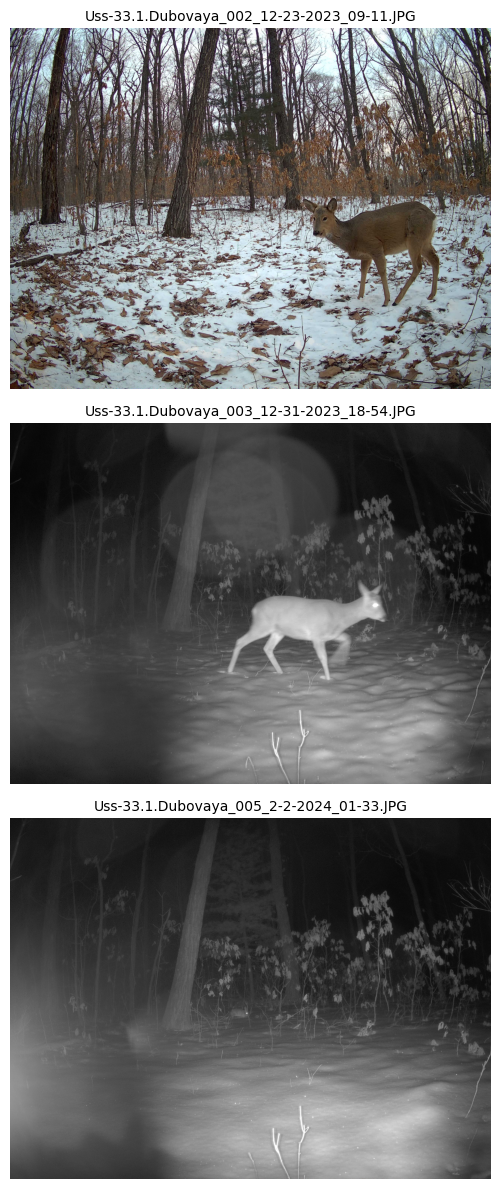

In [53]:
import cv2
import matplotlib.pyplot as plt

# Function to display multiple images
def plot_images(df, indices, image_folder):
    """
    Plots multiple images from the given DataFrame based on specified indices.

    Args:
        df (pd.DataFrame): DataFrame containing image file names.
        indices (list): List of indices of the images to plot.
        image_folder (str): Path to the folder containing the images.
    """
    plt.figure(figsize=(15, len(indices) * 4)) 
    for i, index in enumerate(indices):
        row = df.iloc[index]
        image_path = f"{image_folder}/{row['name']}"
        image = cv2.imread(image_path)
        plt.subplot(len(indices), 1, i + 1)  # Plot images in a single column
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
            plt.imshow(image)
            plt.title(row['name'], fontsize=10)
        else:
            plt.title(f"Image not found: {row['name']}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


image_folder = '/home/jovyan/__ANIMALS/images' 
indices_to_plot = list(range(len(filtered_df)))[:3]  # Adjust to the desired number of images
plot_images(filtered_df, indices_to_plot, image_folder)


### Now we will extract the date and time of the rest of the data with no metadata

In [65]:
import pandas as pd
import re

# Function to extract date and time from the image name
def extract_metadata_from_name(image_name):
    """
    Extracts the date and time from an image name using regex patterns.

    Args:
        image_name (str): The name of the image file.

    Returns:
        tuple: Extracted date, time, and a placeholder for temperature (None).
    """
    # Regular expressions for date and time
    date_pattern = r"(\d{1,2}-\d{1,2}-\d{4})"  # Matches MM-DD-YYYY, allowing single-digit months and days
    time_pattern = r"_(\d{2}-\d{2})\."         # Matches _HH-MM. (time surrounded by underscores or followed by .)

    # Extract date and time using regular expressions
    date_match = re.search(date_pattern, image_name)
    date = date_match.group(1) if date_match else None
    time_match = re.search(time_pattern, image_name)
    time = time_match.group(1) if time_match else None

    # Standardize date and time formats
    if date:
        date = pd.to_datetime(date, format='%m-%d-%Y').strftime('%d/%m/%Y')
    if time:
        time = pd.to_datetime(time, format='%H-%M').strftime('%H:%M:%S')

    return date, time, None  # Placeholder for temperature

# Apply the function to extract components and create new columns
filtered_df[['date', 'time', 'temperature']] = filtered_df['name'].apply(
    lambda x: pd.Series(extract_metadata_from_name(x))
)

# Display the result
filtered_df.head()

/tmp/ipykernel_4258/3198277716.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[['date', 'time', 'temperature']] = filtered_df['name'].apply(


name            shape  \
1          Uss-33.1.Dubovaya_002_12-23-2023_09-11.JPG  (1944, 2592, 3)   
2          Uss-33.1.Dubovaya_003_12-31-2023_18-54.JPG  (1944, 2592, 3)   
3            Uss-33.1.Dubovaya_005_2-2-2024_01-33.JPG  (1944, 2592, 3)   
4            Uss-33.1.Dubovaya_006_2-5-2024_10-38.JPG  (1944, 2592, 3)   
41  Uss-39.1.Rakovkacrossing_004_12-21-2023_22-47.JPG  (1944, 2592, 3)   

   metadata        date      time temperature  
1            23/12/2023  09:11:00        None  
2            31/12/2023  18:54:00        None  
3            02/02/2024  01:33:00        None  
4            05/02/2024  10:38:00        None  
41           21/12/2023  22:47:00        None

In [59]:
# Print the name column for a few rows
for index, row in filtered_df.head(5).iterrows():
    print(f"Row {index}: {row['name']}\n")

Row 1: Uss-33.1.Dubovaya_002_12-23-2023_09-11.JPG

Row 2: Uss-33.1.Dubovaya_003_12-31-2023_18-54.JPG

Row 3: Uss-33.1.Dubovaya_005_2-2-2024_01-33.JPG

Row 4: Uss-33.1.Dubovaya_006_2-5-2024_10-38.JPG

Row 41: Uss-39.1.Rakovkacrossing_004_12-21-2023_22-47.JPG



In [67]:
filtered_df.head(15)

name            shape  \
1          Uss-33.1.Dubovaya_002_12-23-2023_09-11.JPG  (1944, 2592, 3)   
2          Uss-33.1.Dubovaya_003_12-31-2023_18-54.JPG  (1944, 2592, 3)   
3            Uss-33.1.Dubovaya_005_2-2-2024_01-33.JPG  (1944, 2592, 3)   
4            Uss-33.1.Dubovaya_006_2-5-2024_10-38.JPG  (1944, 2592, 3)   
41  Uss-39.1.Rakovkacrossing_004_12-21-2023_22-47.JPG  (1944, 2592, 3)   
42  Uss-39.1.Rakovkacrossing_005_12-22-2023_05-03.JPG  (1944, 2592, 3)   
43  Uss-39.1.Rakovkacrossing_035_12-29-2023_02-09.JPG  (1944, 2592, 3)   
44    Uss-39.1.Rakovkacrossing_085_1-4-2024_20-51.JPG  (1944, 2592, 3)   
45    Uss-39.1.Rakovkacrossing_106_1-6-2024_22-43.JPG  (1944, 2592, 3)   
46   Uss-39.1.Rakovkacrossing_191_1-25-2024_19-59.JPG  (1944, 2592, 3)   
47   Uss-39.1.Rakovkacrossing_192_1-25-2024_19-59.JPG  (1944, 2592, 3)   
48   Uss-39.1.Rakovkacrossing_193_1-25-2024_19-59.JPG  (1944, 2592, 3)   
49   Uss-39.1.Rakovkacrossing_194_1-25-2024_19-59.JPG  (1944, 2592, 3)   
50   Uss-39.1.Rakovkacrossing_195_1-25-2024_19-59.JPG  (1944, 2592, 3)   
51   Uss-39.1.Rakovkacrossing_196_1-25-2024_19-59.JPG  (1944, 2592, 3)   

   metadata        date      time temperature  
1            23/12/2023  09:11:00        None  
2            31/12/2023  18:54:00        None  
3            02/02/2024  01:33:00        None  
4            05/02/2024  10:38:00        None  
41           21/12/2023  22:47:00        None  
42           22/12/2023  05:03:00        None  
43           29/12/2023  02:09:00        None  
44           04/01/2024  20:51:00        None  
45           06/01/2024  22:43:00        None  
46           25/01/2024  19:59:00        None  
47           25/01/2024  19:59:00        None  
48           25/01/2024  19:59:00        None  
49           25/01/2024  19:59:00        None  
50           25/01/2024  19:59:00        None  
51           25/01/2024  19:59:00        None

In [71]:
# Concatenate all columns
df_combined_cleaned = pd.concat([df_combined_cleaned, filtered_df], ignore_index=True)

# Check the result
df_combined_cleaned.head(10)

name            shape  \
0  Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG  (1536, 2048, 3)   
1  Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG  (1536, 2048, 3)   
2  Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG  (1536, 2048, 3)   
3  Uss-1.1.AnikinRidge_005_12-22-2023_15-41.JPG  (1536, 2048, 3)   
4    Uss-1.1.AnikinRidge_006_1-8-2024_19-13.JPG  (1536, 2048, 3)   
5   Uss-1.1.AnikinRidge_007_1-13-2024_13-12.JPG  (1536, 2048, 3)   
6   Uss-1.1.AnikinRidge_008_1-20-2024_15-10.JPG  (1536, 2048, 3)   
7   Uss-1.1.AnikinRidge_009_1-20-2024_15-55.JPG  (1536, 2048, 3)   
8   Uss-1.1.AnikinRidge_010_1-20-2024_15-59.JPG  (1536, 2048, 3)   
9   Uss-1.1.AnikinRidge_011_1-21-2024_13-39.JPG  (1536, 2048, 3)   

                                  metadata error        date      time  \
0  SEELOCK #01 M 17/12/2023 15:00:21 -19°C   NaN  17/12/2023  15:00:21   
1  SEELOCK #01 W 21/12/2023 09:22:24 -26°C   NaN  21/12/2023  09:22:24   
2  SEELOCK #01 M 22/12/2023 15:40:26 -19°C   NaN  22/12/2023  15:40:26   
3  SEELOCK #01 M 22/12/2023 15:41.12 -18°C   NaN  22/12/2023  15:41:00   
4  SEELOCK #01 M 08/01/2024 19:13:17 -15°C   NaN  08/01/2024  19:13:17   
5  SEELOCK #01 M 13/01/2024 13:12:30 -16°C   NaN  13/01/2024  13:12:30   
6  SEELOCK #01 M 20/01/2024 15:10:12 -13°C   NaN  20/01/2024  15:10:12   
7  SEELOCK #01 M 20/01/2024 15:55:27 -12°C   NaN  20/01/2024  15:55:27   
8  SEELOCK #01 M 20/01/2024 15:59:46 -12°C   NaN  20/01/2024  15:59:46   
9  SEELOCK #01 M 21/01/2024 13:39:46 -16°C   NaN  21/01/2024  13:39:46   

  temperature  
0         -19  
1         -26  
2         -19  
3         -18  
4         -15  
5         -16  
6         -13  
7         -12  
8         -12  
9         -16

In [72]:
# Drop the 'error' column
df_combined_cleaned_no_error = df_combined_cleaned.drop(columns=['error'])

# Save to CSV
df_combined_cleaned_no_error.to_csv('final_meta_data.csv', index=False)


In [73]:
metadata = pd.read_csv('final_meta_data.csv')

In [74]:
metadata.head(5)

name            shape  \
0  Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG  (1536, 2048, 3)   
1  Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG  (1536, 2048, 3)   
2  Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG  (1536, 2048, 3)   
3  Uss-1.1.AnikinRidge_005_12-22-2023_15-41.JPG  (1536, 2048, 3)   
4    Uss-1.1.AnikinRidge_006_1-8-2024_19-13.JPG  (1536, 2048, 3)   

                                  metadata        date      time  temperature  
0  SEELOCK #01 M 17/12/2023 15:00:21 -19°C  17/12/2023  15:00:21        -19.0  
1  SEELOCK #01 W 21/12/2023 09:22:24 -26°C  21/12/2023  09:22:24        -26.0  
2  SEELOCK #01 M 22/12/2023 15:40:26 -19°C  22/12/2023  15:40:26        -19.0  
3  SEELOCK #01 M 22/12/2023 15:41.12 -18°C  22/12/2023  15:41:00        -18.0  
4  SEELOCK #01 M 08/01/2024 19:13:17 -15°C  08/01/2024  19:13:17        -15.0

In [80]:
len(metadata['name'].unique())

7054

In [81]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7435 entries, 0 to 7434
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         7435 non-null   object 
 1   shape        7435 non-null   object 
 2   metadata     6914 non-null   object 
 3   date         7435 non-null   object 
 4   time         7435 non-null   object 
 5   temperature  6895 non-null   float64
dtypes: float64(1), object(5)
memory usage: 348.6+ KB


In [82]:
metadata_cleaned = metadata.drop_duplicates(subset='name', keep='first')

In [83]:
metadata_cleaned.head(15)

name            shape  \
0   Uss-1.1.AnikinRidge_002_12-17-2023_15-00.JPG  (1536, 2048, 3)   
1   Uss-1.1.AnikinRidge_003_12-21-2023_09-22.JPG  (1536, 2048, 3)   
2   Uss-1.1.AnikinRidge_004_12-22-2023_15-40.JPG  (1536, 2048, 3)   
3   Uss-1.1.AnikinRidge_005_12-22-2023_15-41.JPG  (1536, 2048, 3)   
4     Uss-1.1.AnikinRidge_006_1-8-2024_19-13.JPG  (1536, 2048, 3)   
5    Uss-1.1.AnikinRidge_007_1-13-2024_13-12.JPG  (1536, 2048, 3)   
6    Uss-1.1.AnikinRidge_008_1-20-2024_15-10.JPG  (1536, 2048, 3)   
7    Uss-1.1.AnikinRidge_009_1-20-2024_15-55.JPG  (1536, 2048, 3)   
8    Uss-1.1.AnikinRidge_010_1-20-2024_15-59.JPG  (1536, 2048, 3)   
9    Uss-1.1.AnikinRidge_011_1-21-2024_13-39.JPG  (1536, 2048, 3)   
10   Uss-1.1.AnikinRidge_012_1-23-2024_18-09.JPG  (1536, 2048, 3)   
11   Uss-1.1.AnikinRidge_013_1-24-2024_10-12.JPG  (1536, 2048, 3)   
12   Uss-1.1.AnikinRidge_014_1-28-2024_02-11.JPG  (1536, 2048, 3)   
13   Uss-1.1.AnikinRidge_015_1-31-2024_02-33.JPG  (1536, 2048, 3)   
14    Uss-1.1.AnikinRidge_016_2-5-2024_02-02.JPG  (1536, 2048, 3)   

                                   metadata        date      time  temperature  
0   SEELOCK #01 M 17/12/2023 15:00:21 -19°C  17/12/2023  15:00:21        -19.0  
1   SEELOCK #01 W 21/12/2023 09:22:24 -26°C  21/12/2023  09:22:24        -26.0  
2   SEELOCK #01 M 22/12/2023 15:40:26 -19°C  22/12/2023  15:40:26        -19.0  
3   SEELOCK #01 M 22/12/2023 15:41.12 -18°C  22/12/2023  15:41:00        -18.0  
4   SEELOCK #01 M 08/01/2024 19:13:17 -15°C  08/01/2024  19:13:17        -15.0  
5   SEELOCK #01 M 13/01/2024 13:12:30 -16°C  13/01/2024  13:12:30        -16.0  
6   SEELOCK #01 M 20/01/2024 15:10:12 -13°C  20/01/2024  15:10:12        -13.0  
7   SEELOCK #01 M 20/01/2024 15:55:27 -12°C  20/01/2024  15:55:27        -12.0  
8   SEELOCK #01 M 20/01/2024 15:59:46 -12°C  20/01/2024  15:59:46        -12.0  
9   SEELOCK #01 M 21/01/2024 13:39:46 -16°C  21/01/2024  13:39:46        -16.0  
10  SEELOCK #01 M 23/01/2024 18:09:40 -20°C  23/01/2024  18:09:40        -20.0  
11  SEELOCK #01 M 24/01/2024 10:12:41 -20°C  24/01/2024  10:12:41        -20.0  
12  SEELOCK #01 M 28/01/2024 02:11:44 -13°C  28/01/2024  02:11:44        -13.0  
13  SEELOCK #01 M 31/01/2024 02:33:34 -06°C  31/01/2024  02:33:34         -6.0  
14  SEELOCK #01 M 05/02/2024 02:02:34 -16°C  05/02/2024  02:02:34        -16.0

In [85]:
metadata_cleaned.to_csv('final_meta_data.csv', index=False)

In [86]:
metadata_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7054 entries, 0 to 7053
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         7054 non-null   object 
 1   shape        7054 non-null   object 
 2   metadata     6914 non-null   object 
 3   date         7054 non-null   object 
 4   time         7054 non-null   object 
 5   temperature  6895 non-null   float64
dtypes: float64(1), object(5)
memory usage: 385.8+ KB
